<a href="https://colab.research.google.com/github/sjhd1109/study/blob/main/sims_modeling_210323.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##3.SIMS DATA
- SIMS Data 에 등록된 기업만 sorting 하여 진행 
  NICE data 약 170만개 중 약 20만개로 구성
  (simsYN -> 1)
- 결산기준 : 2008년 3월 ~ 2017년 (NICE 에서 제공하는 재무데이터 기준)
- 부도기준 : 결산년도, 부도기준일자 에 따라 '정상' '부도' 
        - 개인사업자 : 결산년도 기준 +5개월 이후 
        - 법인사업자 : 결산년도 기준 +3개월 이후
- 기존 NICE 데이터의 재무 비율 및 변수와 동일
- test/train set 30% 70% 비율, 부도 값도 동일한 비율로 나누어서 진행
- 부도 갯수 : 735개 / 정상 : 130,717개 (trian_set : 131,452 개) 로 
  부도 비율 0.05%
- 추가변수 : 자금 지원 및 특허출원 갯수 + 재무비율

    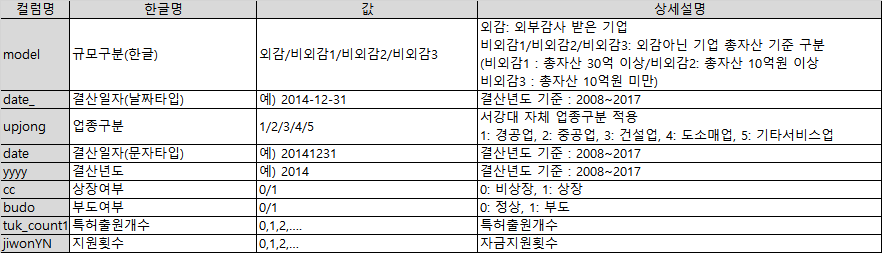

* 재무비율 변수

    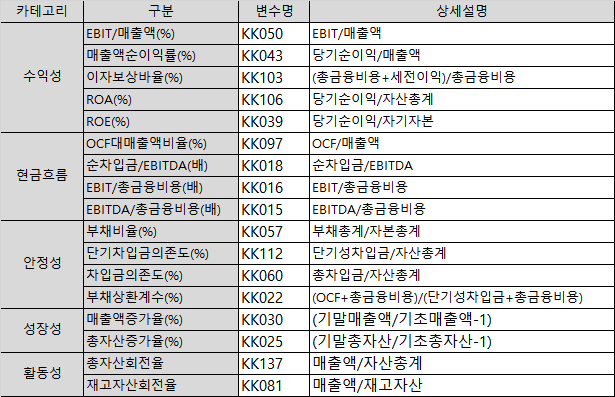

In [ ]:
install.packages("Information")
install.packages("scorecard")
install.packages("ggridges")
install.packages("woe")
install.packages("writexl")
install.packages("caret")

In [ ]:
library(readxl)
library(data.table)
library(dplyr)
library(scorecard)
library(ggplot2)
library(ggridges)
library(woe)
library(Information)
library(caret)
library(writexl)

- 변수 속성

  범주형 : model(비외감,외감), upjong(업종), cc(상장,비상장), budo(부도여부)

  연속형 : 이외의 모든 변수(재무비율 포함)

In [ ]:
train_df_sim <- read.table('/content/sample_data/train_df_sim.txt', header =T,  fileEncoding="euc-kr" )


In [ ]:
train_df_sim$model <- substr(train_df_sim$model, 2,2) 
train_df_sim $model <- as.factor(train_df_sim $model)
train_df_sim $upjong <- as.factor(train_df_sim $upjong)
train_df_sim $jiwonYN	 <- as.character(train_df_sim $jiwonYN)
train_df_sim $cc	 <- as.factor(train_df_sim $cc)
train_df_sim <- train_df_sim[,-c(4,5)]
head(train_df_sim)

In [ ]:
str(train_df_sim)

'data.frame':	131452 obs. of  22 variables:
 $ model : Factor w/ 1 level "": 1 1 1 1 1 1 1 1 1 1 ...
 $ date  : int  20081231 20081231 20091231 20111231 20081231 20141231 20151231 20081231 20121231 20131231 ...
 $ upjong: Factor w/ 5 levels "1","2","3","4",..: 1 1 1 1 2 2 2 2 2 2 ...
 $ KK050 : num  3.69 6.12 5.61 7.44 8.37 ...
 $ KK043 : num  2.425 1.435 0.664 2.432 6.971 ...
 $ KK103 : num  2.92 1.56 1.14 1.45 6 ...
 $ KK106 : num  4.419 1.561 0.721 3.322 16.791 ...
 $ KK039 : num  9.92 4.51 2.96 20.93 47.87 ...
 $ KK097 : num  0 0 0 0 0 0 0 0 0 0 ...
 $ KK018 : num  4.3 8.9 6.92 8.16 15.26 ...
 $ KK016 : num  341 190 140 163 1094 ...
 $ KK015 : num  341 190 140 163 1094 ...
 $ KK057 : num  76 281 360 338 172 ...
 $ KK112 : num  22.8 63.1 67.8 69.3 44.4 ...
 $ KK060 : num  22.8 63.1 68.8 73.5 44.4 ...
 $ KK022 : num  31.2 12.3 10.2 15 77 ...
 $ KK030 : num  1.85 7.5 -2.59 1.45 47.37 ...
 $ KK025 : num  12.53 -12.78 -2.46 -3.52 3.08 ...
 $ KK137 : num  1.93 1.01 1.07 1.34 2.45 ...
 $ 

In [ ]:
summary(train_df_sim)

 model          date          upjong        KK050           KK043       
 :131452   Min.   :20081231   1:24292   Min.   :-2912   Min.   :-13756  
           1st Qu.:20121231   2:59640   1st Qu.:    6   1st Qu.:     4  
           Median :20151231   3: 2588   Median :    9   Median :     7  
           Mean   :20141966   4:27865   Mean   :   11   Mean   :     7  
           3rd Qu.:20161231   5:17067   3rd Qu.:   13   3rd Qu.:    10  
           Max.   :20171231             Max.   : 2038   Max.   :  1716  
     KK103            KK106           KK039              KK097     
 Min.   :-73212   Min.   : -582   Min.   :-3601310   Min.   :-153  
 1st Qu.:     3   1st Qu.:    5   1st Qu.:      15   1st Qu.:   0  
 Median :     6   Median :   10   Median :      33   Median :   0  
 Mean   :    54   Mean   :   15   Mean   :    1401   Mean   :   0  
 3rd Qu.:    14   3rd Qu.:   18   3rd Qu.:      68   3rd Qu.:   0  
 Max.   :385780   Max.   :23017   Max.   : 8309323   Max.   : 183  
     KK018   

- WOE 값 
  각 변수별 BINNING : 50개
  BAD(부도) : 0 , GOOD(정상) : 1 COUNT

In [ ]:
KK050 <- data.frame(woe(Data = train_df_sim, Independent = "KK050", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK043 <- data.frame(woe(Data = train_df_sim, Independent = "KK043", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK103 <- data.frame(woe(Data = train_df_sim, Independent = "KK103", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK106 <- data.frame(woe(Data = train_df_sim, Independent = "KK106", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK039 <- data.frame(woe(Data = train_df_sim, Independent = "KK039", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK097 <- data.frame(woe(Data = train_df_sim, Independent = "KK097", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK018 <- data.frame(woe(Data = train_df_sim, Independent = "KK018", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK016 <- data.frame(woe(Data = train_df_sim, Independent = "KK016", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK015 <- data.frame(woe(Data = train_df_sim, Independent = "KK015", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK057 <- data.frame(woe(Data = train_df_sim, Independent = "KK057", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK112 <- data.frame(woe(Data = train_df_sim, Independent = "KK112", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK060 <- data.frame(woe(Data = train_df_sim, Independent = "KK060", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK022 <- data.frame(woe(Data = train_df_sim, Independent = "KK022", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK030 <- data.frame(woe(Data = train_df_sim, Independent = "KK030", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK025 <- data.frame(woe(Data = train_df_sim, Independent = "KK025", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK137 <- data.frame(woe(Data = train_df_sim, Independent = "KK137", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK081 <- data.frame(woe(Data = train_df_sim, Independent = "KK081", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
KK081 <- data.frame(woe(Data = train_df_sim, Independent = "KK081", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
tuk_count1 <- data.frame(woe(Data = train_df_sim, Independent = "tuk_count1", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))
jiwonYN <- data.frame(woe(Data = train_df_sim, Independent = "jiwonYN", Continuous = TRUE, Dependent = "budo", C_Bin = 50, Bad = 0, Good = 1))

In [ ]:
KK050$WOE[is.infinite(KK050$WOE)] <- 0
KK043$WOE[is.infinite(KK043$WOE)] <- 0
KK103$WOE[is.infinite(KK103$WOE)] <- 0
KK106$WOE[is.infinite(KK106$WOE)] <- 0
KK039$WOE[is.infinite(KK039$WOE)] <- 0
KK097$WOE[is.infinite(KK097$WOE)] <- 0
KK018$WOE[is.infinite(KK018$WOE)] <- 0
KK016$WOE[is.infinite(KK016$WOE)] <- 0
KK015$WOE[is.infinite(KK015$WOE)] <- 0
KK057$WOE[is.infinite(KK057$WOE)] <- 0
KK112$WOE[is.infinite(KK112$WOE)] <- 0
KK060$WOE[is.infinite(KK060$WOE)] <- 0
KK022$WOE[is.infinite(KK022$WOE)] <- 0
KK030$WOE[is.infinite(KK030$WOE)] <- 0
KK025$WOE[is.infinite(KK025$WOE)] <- 0
KK137$WOE[is.infinite(KK137$WOE)] <- 0
KK081$WOE[is.infinite(KK081$WOE)] <- 0
tuk_count1$WOE[is.infinite(tuk_count1$WOE)] <- 0
jiwonYN$WOE[is.infinite(jiwonYN$WOE)] <- 0


KK050$WOE <- KK050$WOE*0.01 
KK043$WOE <- KK043$WOE*0.01 
KK103$WOE <- KK103$WOE*0.01 
KK106$WOE <- KK106$WOE*0.01 
KK039$WOE <- KK039$WOE*0.01 
KK097$WOE <- KK097$WOE*0.01 
KK018$WOE <- KK018$WOE*0.01 
KK016$WOE <- KK016$WOE*0.01 
KK015$WOE <- KK015$WOE*0.01 
KK057$WOE <- KK057$WOE*0.01 
KK112$WOE <- KK112$WOE*0.01 
KK060$WOE <- KK060$WOE*0.01 
KK022$WOE <- KK022$WOE*0.01 
KK030$WOE <- KK030$WOE*0.01 
KK025$WOE <- KK025$WOE*0.01 
KK137$WOE <- KK137$WOE*0.01 
KK081$WOE <- KK081$WOE*0.01 
tuk_count1$WOE <- tuk_count1$WOE*0.01
jiwonYN$WOE <- jiwonYN$WOE*0.01


- WOE 증감 그래프
  변수별 WOE 값 증가/감소/변화없음에 따라 FALSE, TRUE 로 측정
  증감에 따른 변화값 

In [ ]:
#KK050
### Inflection point
### concave upwards to downward  / concave downward to upwards
### increseing to decreaseing  / decreaseing to increasing
diff(KK050$WOE)>0          # 증가 T, 감소/변화없음 F
### positive to negative / negative to postive
diff( diff(KK050$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl = c(FALSE,  diff(diff(KK050$WOE)>0)!=0, FALSE)
data <- data.table(KK050$BIN,KK043$WOE,infl)
sdata <- data[infl==T,]


#KK043
diff(KK043$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK043$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK043 = c(FALSE,  diff(diff(KK043$WOE)>0)!=0, FALSE)
data_KK043 <- data.table(KK043$BIN,KK043$WOE,infl_KK043)
sdata_KK043 <- data_KK043[infl_KK043==T,]


#KK103
diff(KK103$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK103$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK103 = c(FALSE,  diff(diff(KK103$WOE)>0)!=0, FALSE)
data_KK103 <- data.table(KK103$BIN,KK103$WOE,infl_KK103)
sdata_KK103 <- data_KK103[infl_KK103==T,]


#KK106
diff(KK106$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK106$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK106 = c(FALSE,  diff(diff(KK106$WOE)>0)!=0, FALSE)
data_KK106 <- data.table(KK106$BIN,KK106$WOE,infl_KK106)
sdata_KK106 <- data_KK106[infl_KK106==T,]

#KK039
diff(KK039$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK039$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK039 = c(FALSE,  diff(diff(KK039$WOE)>0)!=0, FALSE)
data_KK039 <- data.table(KK039$BIN,KK039$WOE,infl_KK039)
sdata_KK039 <- data_KK039[infl_KK039==T,]


#KK097
diff(KK097$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK097$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK097 = c(FALSE,  diff(diff(KK097$WOE)>0)!=0, FALSE)
data_KK097 <- data.table(KK097$BIN,KK097$WOE,infl_KK097)
sdata_KK097 <- data_KK097[infl_KK097==T,]


#KK018
diff(KK018$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK018$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK018 = c(FALSE,  diff(diff(KK018$WOE)>0)!=0, FALSE)
data_KK018 <- data.table(KK018$BIN,KK018$WOE,infl_KK018)
sdata_KK018 <- data_KK018[infl_KK018==T,]


#KK018
diff(KK016$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK016$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK016 = c(FALSE,  diff(diff(KK016$WOE)>0)!=0, FALSE)
data_KK016 <- data.table(KK016$BIN,KK016$WOE,infl_KK016)
sdata_KK016 <- data_KK016[infl_KK016==T,]


#KK015
diff(KK015$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK015$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK015 = c(FALSE,  diff(diff(KK015$WOE)>0)!=0, FALSE)
data_KK015 <- data.table(KK015$BIN,KK015$WOE,infl_KK015)
sdata_KK015 <- data_KK015[infl_KK015==T,]

#KK057
diff(KK057$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK057$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK057 = c(FALSE,  diff(diff(KK057$WOE)>0)!=0, FALSE)
data_KK057 <- data.table(KK057$BIN,KK057$WOE,infl_KK057)
sdata_KK057 <- data_KK057[infl_KK057==T,]

#KK112
diff(KK112$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK112$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK112 = c(FALSE,  diff(diff(KK112$WOE)>0)!=0, FALSE)
data_KK112 <- data.table(KK112$BIN,KK112$WOE,infl_KK112)
sdata_KK112 <- data_KK112[infl_KK112==T,]

#KK060
diff(KK060$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK060$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK060 = c(FALSE,  diff(diff(KK060$WOE)>0)!=0, FALSE)
data_KK060 <- data.table(KK060$BIN,KK060$WOE,infl_KK060)
sdata_KK060 <- data_KK060[infl_KK060==T,]

#KK022
diff(KK022$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK022$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK022 = c(FALSE,  diff(diff(KK022$WOE)>0)!=0, FALSE)
data_KK022 <- data.table(KK022$BIN,KK022$WOE,infl_KK022)
sdata_KK022 <- data_KK022[infl_KK022==T,]

#KK030
diff(KK030$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK030$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK030 = c(FALSE,  diff(diff(KK030$WOE)>0)!=0, FALSE)
data_KK030 <- data.table(KK030$BIN,KK030$WOE,infl_KK030)
sdata_KK030 <- data_KK030[infl_KK030==T,]

#KK025
diff(KK025$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK025$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK025 = c(FALSE,  diff(diff(KK025$WOE)>0)!=0, FALSE)
data_KK025 <- data.table(KK025$BIN,KK025$WOE,infl_KK025)
sdata_KK025 <- data_KK025[infl_KK025==T,]

#KK137
diff(KK137$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK137$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK137 = c(FALSE,  diff(diff(KK137$WOE)>0)!=0, FALSE)
data_KK137 <- data.table(KK137$BIN,KK137$WOE,infl_KK137)
sdata_KK137 <- data_KK137[infl_KK137==T,]

#KK081
diff(KK081$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(KK081$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_KK081 = c(FALSE,  diff(diff(KK081$WOE)>0)!=0, FALSE)
data_KK081 <- data.table(KK081$BIN,KK081$WOE,infl_KK081)
sdata_KK081 <- data_KK081[infl_KK081==T,]

#tuk_count1
diff(tuk_count1$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(tuk_count1$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_tuk_count1 = c(FALSE,  diff(diff(tuk_count1$WOE)>0)!=0, FALSE)
data_tuk_count1 <- data.table(tuk_count1$BIN,tuk_count1$WOE,infl_tuk_count1)
sdata_tuk_count1 <- data_tuk_count1[infl_tuk_count1==T,]


#jiwonYN
diff(jiwonYN$WOE)>0          # 증가 T, 감소/변화없음 F
diff( diff(jiwonYN$WOE)>0 )  # -1 c(T,F) 증가하다감소, 0 c(T,T) c(F,F) 유지 , 1 c(F,T) 감소하다 증가 
infl_jiwonYN = c(FALSE,  diff(diff(jiwonYN$WOE)>0)!=0, FALSE)
data_jiwonYN <- data.table(jiwonYN$BIN,jiwonYN$WOE,infl_jiwonYN)
sdata_jiwonYN <- data_jiwonYN[infl_jiwonYN==T,]



## WOE BINNING 그래프

- X 축 : BIN 1 ~ 50 까지
- Y 축 : WOE 값 -2 ~ 1 까지 

- 특허 출원 개수


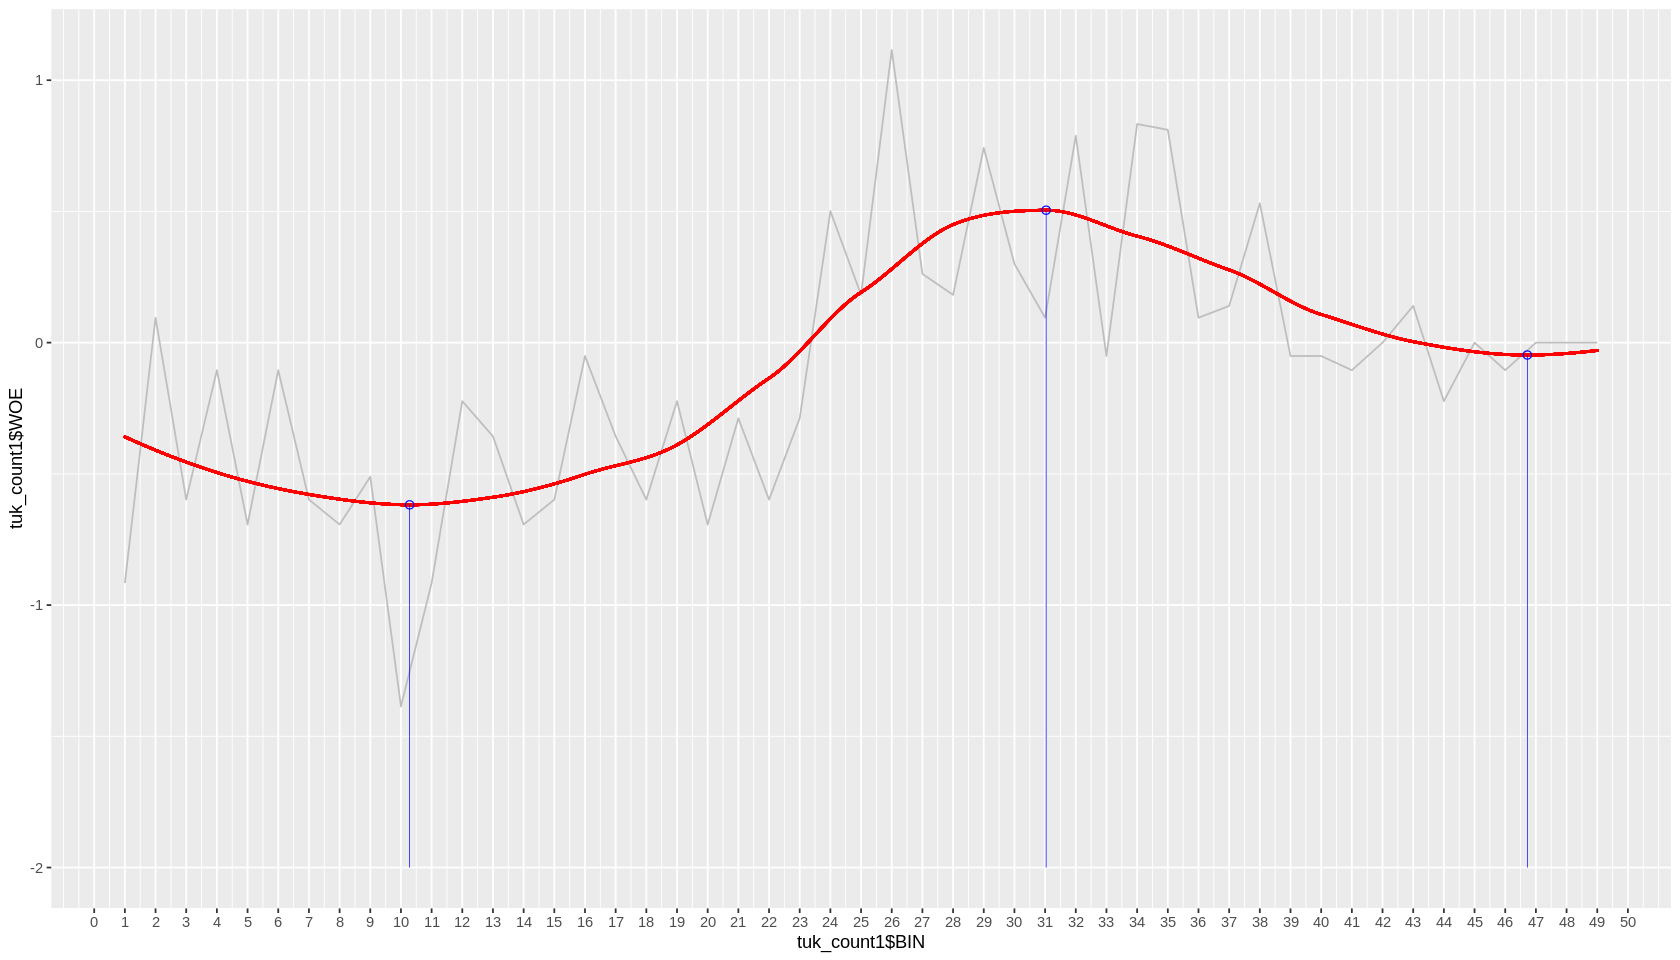

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_tuk_count1 <- loess(tuk_count1$WOE~tuk_count1$BIN, span=0.5)
xl_tuk_count1  <- seq(min(tuk_count1$BIN),max(tuk_count1$BIN), (max(tuk_count1$BIN)-min(tuk_count1$BIN))/200000)
out_tuk_count1 <- predict(smoothing_tuk_count1, xl_tuk_count1)
infl_tuk_count1<- c(diff(diff(out_tuk_count1)>0)!=0,F,F)

### LINE ----
sdata_tuk_count1 <- data.table(xl_tuk_count1,out_tuk_count1, infl_tuk_count1)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_tuk_count1, aes(tuk_count1$BIN,tuk_count1$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_tuk_count1, aes(xl_tuk_count1, out_tuk_count1), size=.1, color="red") +
  geom_point(data=sdata_tuk_count1[infl_tuk_count1], aes(xl_tuk_count1, out_tuk_count1), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_tuk_count1[infl_tuk_count1], aes(x=xl_tuk_count1, y=-2, xend=xl_tuk_count1, yend=out_tuk_count1),color='blue', size=0.2) +
  scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl_tuk_count1]

xl,out,infl
<dbl>,<dbl>,<lgl>
10.28272,0.05544226,FALSE
31.03312,-0.24493416,FALSE
46.72072,-0.37065563,FALSE


- BINNING 결과 테이블

In [ ]:

a <- subset(tuk_count1, BIN <= 46 )
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

d <- subset(tuk_count1, BIN >46 )
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])

total <- rbind(a2,d2)
BIN <- c(1,2)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<int>,<int>,<int>,<int>,<int>
1,0,0,122728,690,123418
2,0,6,7989,45,8034


- 자금지원횟수

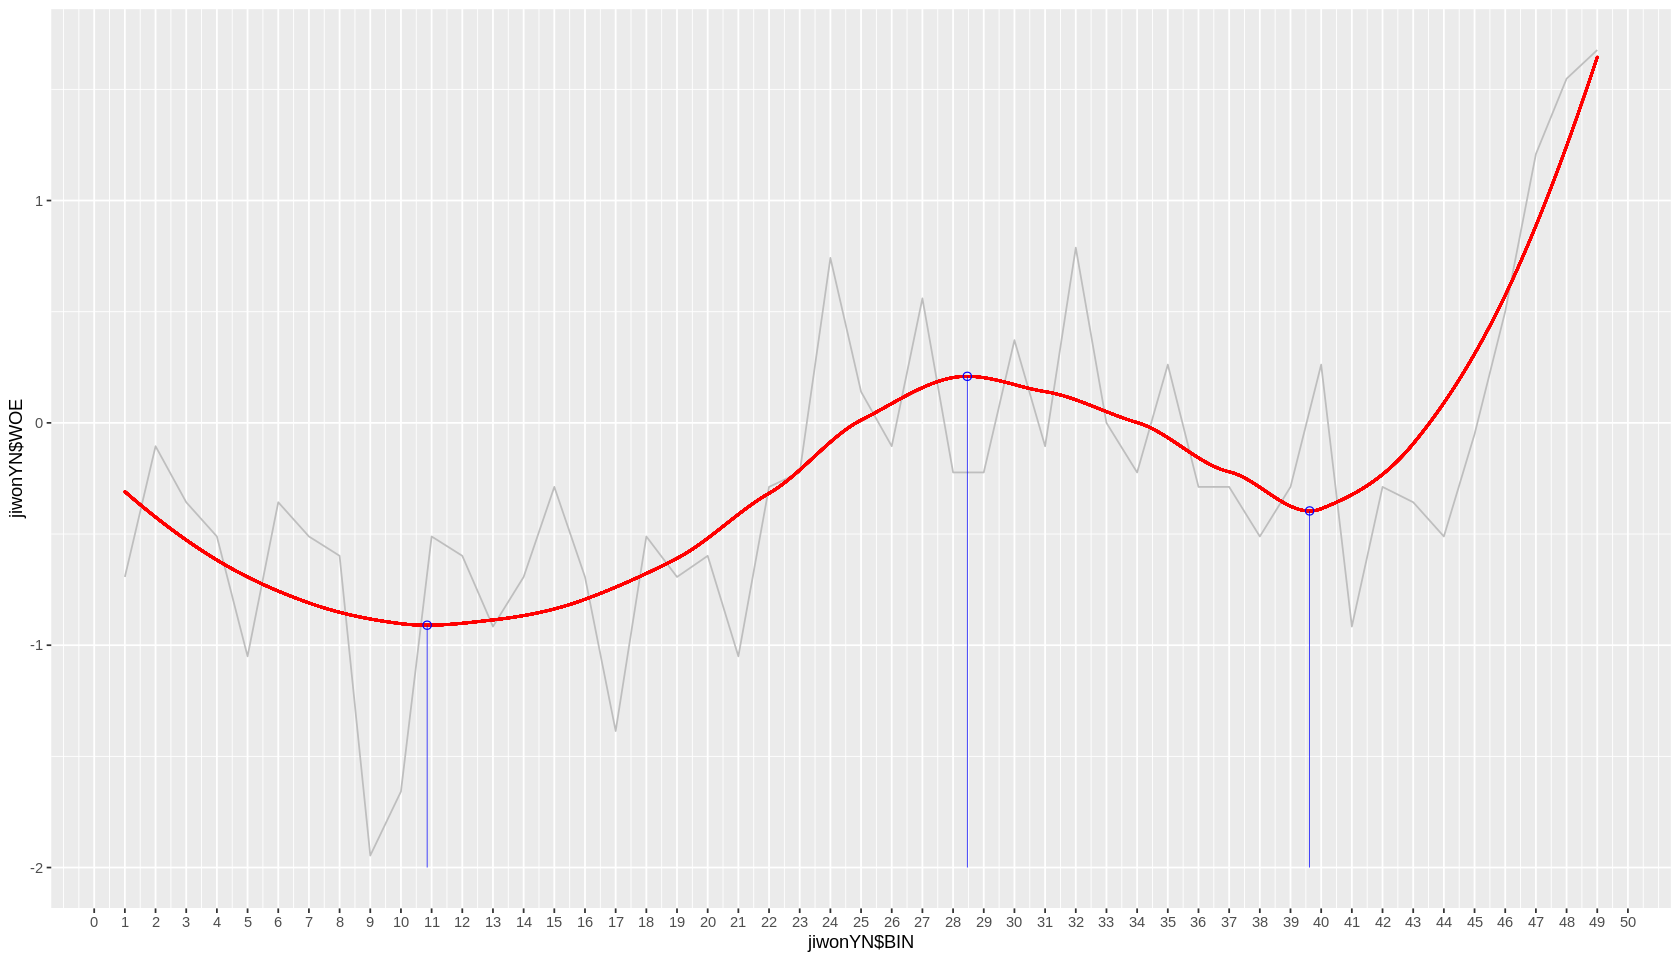

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_jiwonYN <- loess(jiwonYN$WOE~jiwonYN$BIN, span=0.5)
xl_jiwonYN  <- seq(min(jiwonYN$BIN),max(jiwonYN$BIN), (max(jiwonYN$BIN)-min(jiwonYN$BIN))/100000)
out_jiwonYN <- predict(smoothing_jiwonYN, xl_jiwonYN)
infl_jiwonYN <- c(diff(diff(out_jiwonYN)>0)!=0,F,F)

### LINE ----
sdata_jiwonYN <- data.table(xl_jiwonYN,out_jiwonYN, infl_jiwonYN)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_jiwonYN, aes(jiwonYN$BIN,jiwonYN$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_jiwonYN, aes(xl_jiwonYN, out_jiwonYN), size=.1, color="red") +
  geom_point(data=sdata_jiwonYN[infl_jiwonYN], aes(xl_jiwonYN, out_jiwonYN), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_jiwonYN[infl_jiwonYN], aes(x=xl_jiwonYN, y=-2, xend=xl_jiwonYN, yend=out_jiwonYN),color='blue', size=0.2) +
  scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

- BINNING 결과 테이블

In [ ]:
a <- subset(jiwonYN, BIN <= 11 )
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(jiwonYN, BIN > 11 & BIN <=46)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])

c <- subset(jiwonYN, BIN  > 46 )
c$cum_bad <- cumsum(c$BAD)
c$cum_good <- cumsum(c$GOOD)
c$cum_total <- cumsum(c$TOTAL)
c1 <- rbind(head(c,1), tail(c, 1))
c2 <- data.table(c1[1,c(2)], c1[2,c(3,14,15,16)])


total <- rbind(a2,b2,c2)
BIN <- c(1,2,3)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,0,0,29428,85,29513
2,0,1,93452,453,93905
3,1,17,7837,197,8034


- KK050 (EBIT/매출액) -> EBIT 이익률 : 수익성 지표

  X축 : BIN (1 ~ 50 까지)
  
  Y축 : WOE (-2 ~ 1 까지)

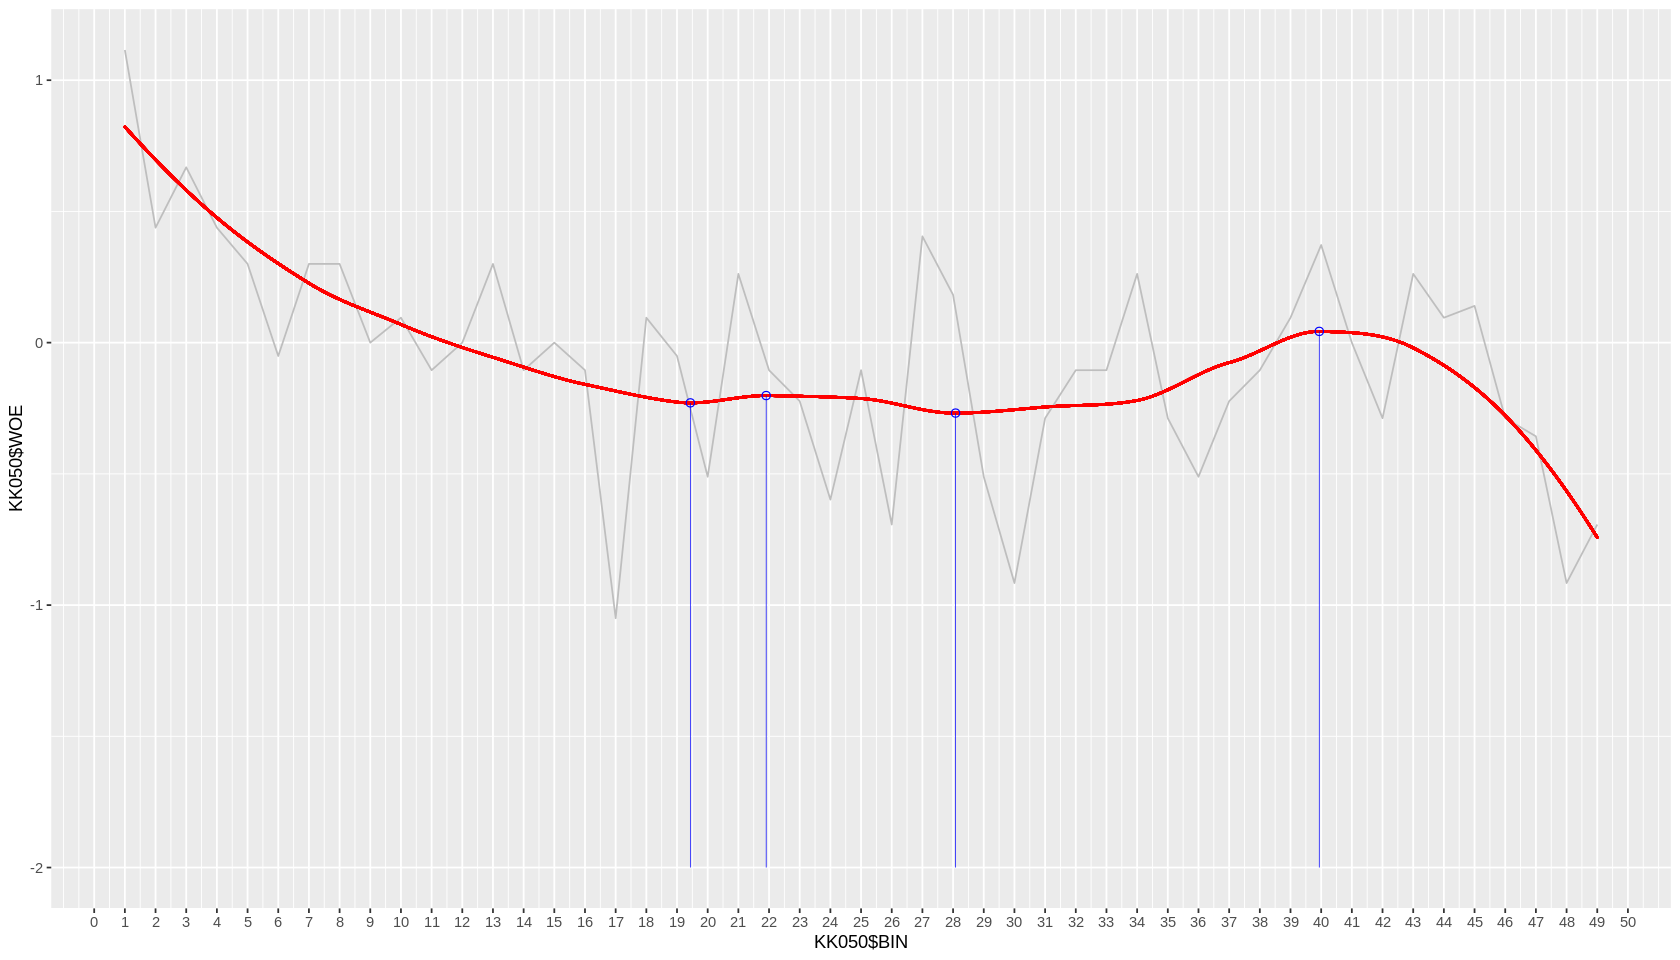

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing <- loess(KK050$WOE~KK050$BIN, span=0.45)
xl  <- seq(min(KK050$BIN),max(KK050$BIN), (max(KK050$BIN)-min(KK050$BIN))/200000)
out <- predict(smoothing, xl)
infl<- c(diff(diff(out)>0)!=0,F,F)

### LINE ----
sdata <- data.table(xl,out, infl)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data, aes(KK050$BIN,KK050$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata, aes(xl, out), size=.1, color="red") +
  geom_point(data=sdata[infl], aes(xl, out), size=2, color="blue", shape=1) +
  geom_segment(data=sdata[infl], aes(x=xl, y=-2, xend=xl, yend=out),color='blue', size=0.2) +
  scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl]

xl,out,infl
<dbl>,<dbl>,<lgl>
19.43464,-0.22944748,TRUE
21.90712,-0.20161743,TRUE
28.08112,-0.26837683,TRUE
39.93808,0.04290613,TRUE


- BINNING 결과 테이블

In [ ]:
a <- subset(KK050, BIN <= 19 )
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(KK050, BIN > 19 & BIN <=22)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])

c <- subset(KK050, BIN  > 22 & BIN <=28)
c$cum_bad <- cumsum(c$BAD)
c$cum_good <- cumsum(c$GOOD)
c$cum_total <- cumsum(c$TOTAL)
c1 <- rbind(head(c,1), tail(c, 1))
c2 <- data.table(c1[1,c(2)], c1[2,c(3,14,15,16)])

d <- subset(KK050, BIN  > 28 & BIN <=40 )
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])

e <- subset(KK050, BIN >40 )
e$cum_bad <- cumsum(e$BAD)
e$cum_good <- cumsum(e$GOOD)
e$cum_total <- cumsum(e$TOTAL)
e1 <- rbind(head(e,1), tail(e, 1))
e2 <- data.table(e1[1,c(2)], e1[2,c(3,14,15,16)])

total <- rbind(a2,b2,c2,d2,e2)
BIN <- c(1,2,3,4,5)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,-2912.00,7.58,50628,349,50977
2,7.58,8.29,8008,41,8049
3,8.29,9.90,16018,80,16098
4,9.90,15.70,32043,153,32196
5,15.70,2038.00,24020,112,24132


- KK043(매출액순이익률) : 수익성 지표

  X축 : BIN (1 ~ 50 까지)
  
  Y축 : WOE (-2 ~ 1 까지)

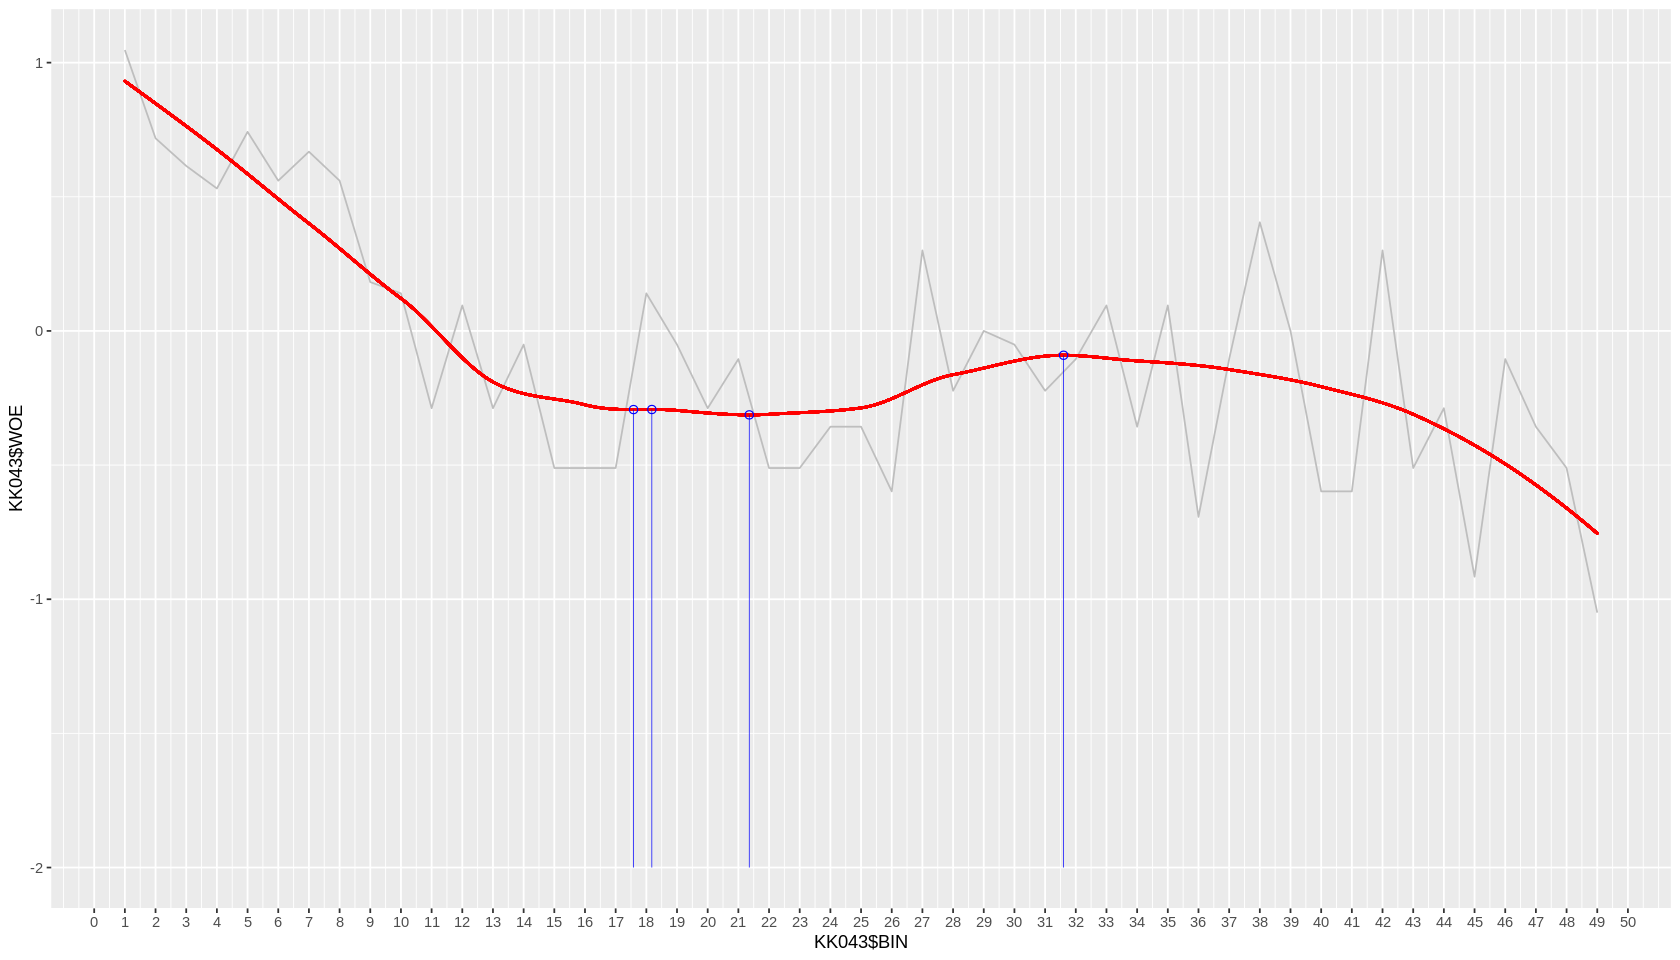

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_KK043 <- loess(KK043$WOE~KK043$BIN, span=0.45)
xl_KK043  <- seq(min(KK043$BIN),max(KK043$BIN), (max(KK043$BIN)-min(KK043$BIN))/200000)
out_KK043 <- predict(smoothing_KK043, xl_KK043)
infl_KK043 <- c(diff(diff(out_KK043)>0)!=0,F,F)

### LINE ----
sdata_KK043 <- data.table(xl_KK043,out_KK043, infl_KK043)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_KK043, aes(KK043$BIN,KK043$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_KK043, aes(xl_KK043, out_KK043), size=.1, color="red") +
  geom_point(data=sdata_KK043[infl_KK043], aes(xl_KK043, out_KK043), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_KK043[infl_KK043], aes(x=xl_KK043, y=-2, xend=xl_KK043, yend=out_KK043),color='blue', size=0.2) +
  scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl_KK043]

xl,out,infl
<dbl>,<dbl>,<lgl>
17.58304,-0.1988083,FALSE
18.17920,-0.2121436,FALSE
21.35536,-0.2051598,FALSE
31.60216,-0.2412024,FALSE


- BINNING 결과 테이블

In [ ]:
a <- subset(KK043, BIN <= 17 )
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(KK043, BIN > 17 & BIN <=18)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])

c <- subset(KK043, BIN  > 18 & BIN <=21)
c$cum_bad <- cumsum(c$BAD)
c$cum_good <- cumsum(c$GOOD)
c$cum_total <- cumsum(c$TOTAL)
c1 <- rbind(head(c,1), tail(c, 1))
c2 <- data.table(c1[1,c(2)], c1[2,c(3,14,15,16)])

d <- subset(KK043, BIN  > 21 & BIN <=31 )
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])

e <- subset(KK043, BIN >31 )
e$cum_bad <- cumsum(e$BAD)
e$cum_good <- cumsum(e$GOOD)
e$cum_total <- cumsum(e$TOTAL)
e1 <- rbind(head(e,1), tail(e, 1))
e2 <- data.table(e1[1,c(2)], e1[2,c(3,14,15,16)])

total <- rbind(a2,b2,c2,d2,e2)
BIN <- c(1,2,3,4,5)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,-13756.00,5.29,45261,350,45611
2,5.29,5.47,2666,17,2683
3,5.47,6.01,8011,38,8049
4,6.01,8.03,26711,119,26830
5,8.03,1716.00,48068,211,48279


- KK103(이자보상비율) : 수익성지표

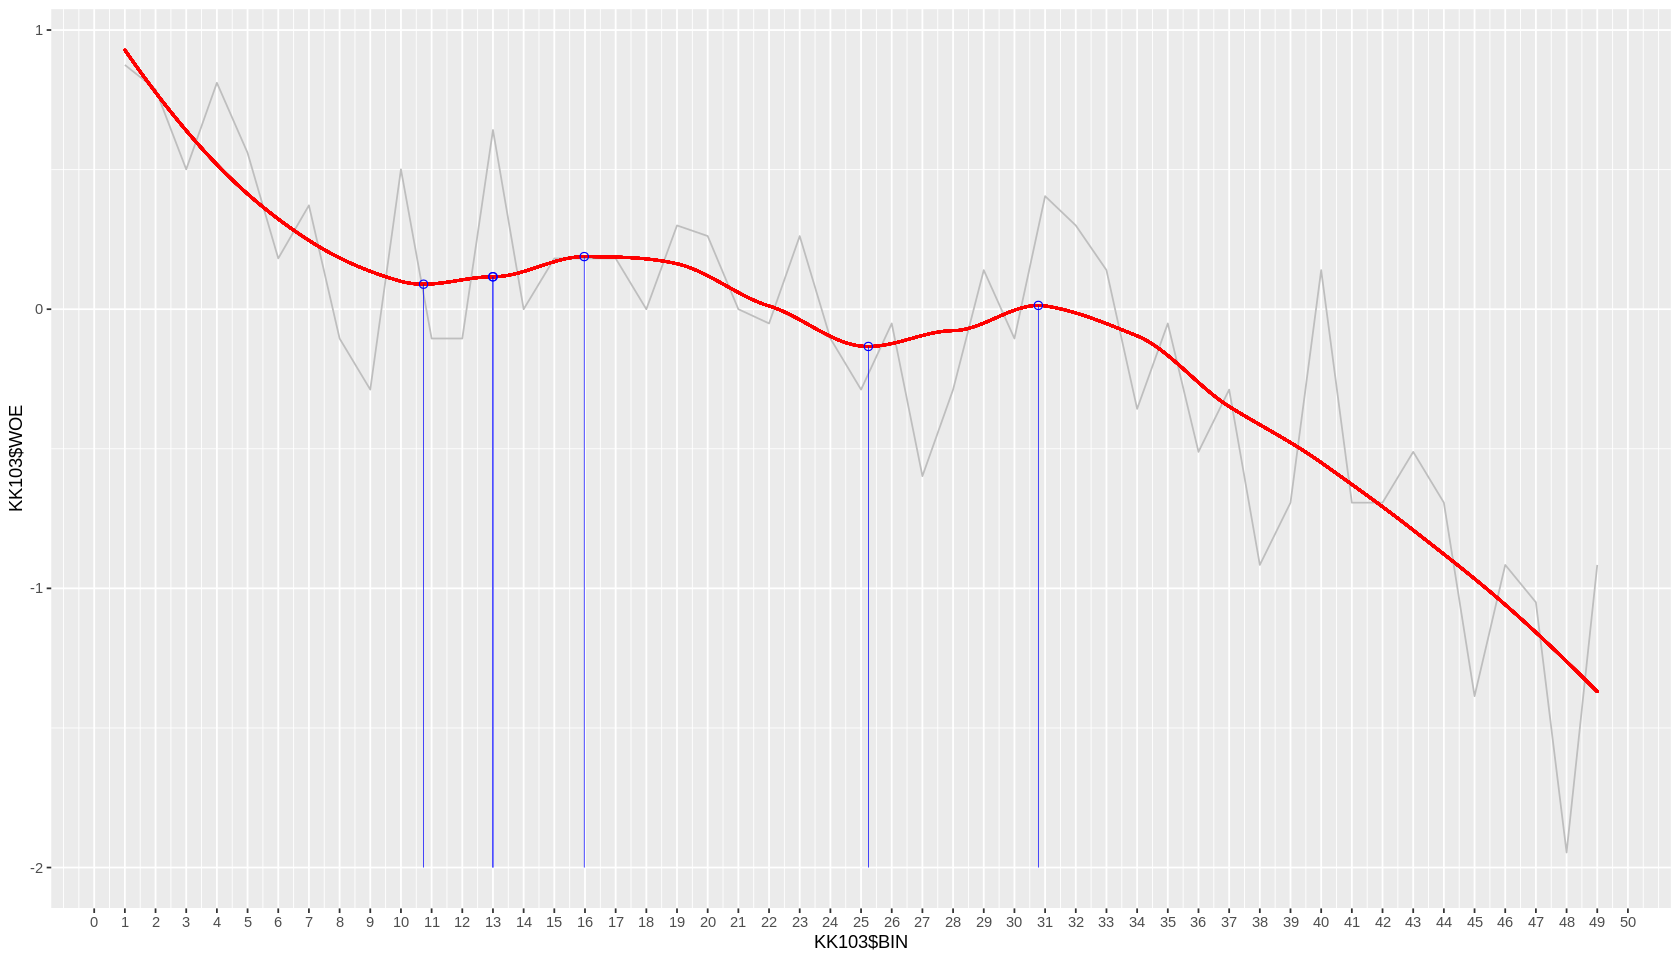

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_KK103<- loess(KK103$WOE~KK103$BIN, span=0.45)
xl_KK103  <- seq(min(KK103$BIN),max(KK103$BIN), (max(KK103$BIN)-min(KK103$BIN))/200000)
out_KK103 <- predict(smoothing_KK103, xl_KK103)
infl_KK103 <- c(diff(diff(out_KK103)>0)!=0,F,F)

### LINE ----
sdata_KK103 <- data.table(xl_KK103,out_KK103, infl_KK103)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_KK103, aes(KK103$BIN,KK103$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_KK103, aes(xl_KK103, out_KK103), size=.1, color="red") +
  geom_point(data=sdata_KK103[infl_KK103], aes(xl_KK103, out_KK103), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_KK103[infl_KK103], aes(x=xl_KK103, y=-2, xend=xl_KK103, yend=out_KK103),color='blue', size=0.2) +
  scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl_KK103]

xl,out,infl
<dbl>,<dbl>,<lgl>
10.7,0.0343,FALSE
13.0,-0.0557,FALSE
13.0,-0.0560,FALSE
16.0,-0.1584,FALSE
25.2,-0.2153,FALSE
30.8,-0.2474,FALSE


- BINNING 결과 테이블

In [ ]:
a <- subset(KK103, BIN <= 10 )
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(KK103, BIN > 10 & BIN <=13)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])

c <- subset(KK103, BIN  > 13 & BIN <=16)
c$cum_bad <- cumsum(c$BAD)
c$cum_good <- cumsum(c$GOOD)
c$cum_total <- cumsum(c$TOTAL)
c1 <- rbind(head(c,1), tail(c, 1))
c2 <- data.table(c1[1,c(2)], c1[2,c(3,14,15,16)])

d <- subset(KK103, BIN  > 16 & BIN <=25 )
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])

e <- subset(KK103, BIN  > 25 & BIN <=30 )
e$cum_bad <- cumsum(e$BAD)
e$cum_good <- cumsum(e$GOOD)
e$cum_total <- cumsum(e$TOTAL)
e1 <- rbind(head(e,1), tail(e, 1))
e2 <- data.table(e1[1,c(2)], e1[2,c(3,14,15,16)])

f <- subset(KK103, BIN >30 )
f$cum_bad <- cumsum(f$BAD)
f$cum_good <- cumsum(f$GOOD)
f$cum_total <- cumsum(f$TOTAL)
f1 <- rbind(head(f,1), tail(f, 1))
f2 <- data.table(f1[1,c(2)], f1[2,c(3,14,15,16)])

total <- rbind(a2,b2,c2,d2,e2,f2)
BIN <- c(1,2,3,4,5,6)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,-73212.00,2.40,26593,237,26830
2,2.40,2.88,7995,54,8049
3,2.88,3.41,7998,51,8049
4,3.41,5.72,24003,144,24147
5,5.72,7.90,13352,63,13415
6,7.90,385780.00,50776,186,50962


- KK106 (ROA 총자산이익률) : 수익성지표

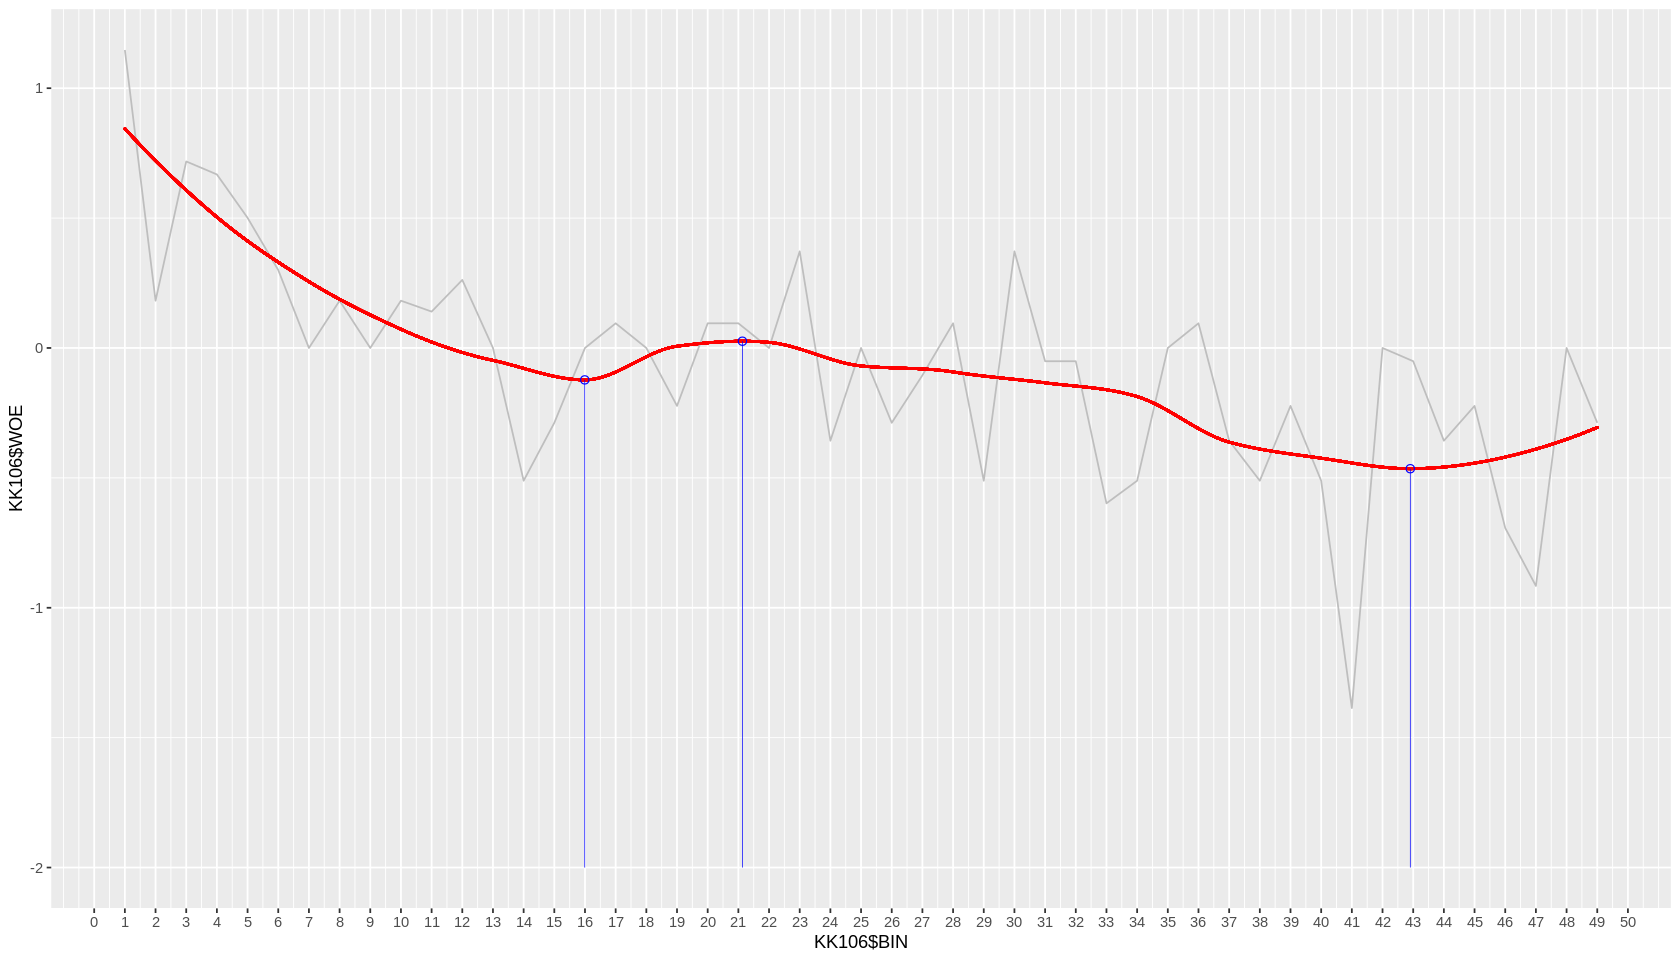

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_KK106<- loess(KK106$WOE~KK106$BIN, span=0.4)
xl_KK106  <- seq(min(KK106$BIN),max(KK106$BIN), (max(KK106$BIN)-min(KK106$BIN))/200000)
out_KK106 <- predict(smoothing_KK106, xl_KK106)
infl_KK106<- c(diff(diff(out_KK106)>0)!=0,F,F)

### LINE ----
sdata_KK106 <- data.table(xl_KK106,out_KK106, infl_KK106)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_KK106, aes(KK106$BIN,KK106$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_KK106, aes(xl_KK106, out_KK106), size=.1, color="red") +
  geom_point(data=sdata_KK106[infl_KK106], aes(xl_KK106, out_KK106), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_KK106[infl_KK106], aes(x=xl_KK106, y=-2, xend=xl_KK106, yend=out_KK106),color='blue', size=0.2) +
   scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl_KK106]

xl,out,infl
<dbl>,<dbl>,<lgl>
15.99232,-0.15878072,FALSE
21.13216,-0.20810953,FALSE
42.90544,-0.01445837,FALSE


- BINNING 결과 테이블

In [ ]:
a <- subset(KK106, BIN <= 16 )
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(KK106, BIN > 16 & BIN <=21)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])

c <- subset(KK106, BIN  > 21 & BIN <=43)
c$cum_bad <- cumsum(c$BAD)
c$cum_good <- cumsum(c$GOOD)
c$cum_total <- cumsum(c$TOTAL)
c1 <- rbind(head(c,1), tail(c, 1))
c2 <- data.table(c1[1,c(2)], c1[2,c(3,14,15,16)])

d <- subset(KK106, BIN >43 )
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])

total <- rbind(a2,b2,c2,d2)
BIN <- c(1,2,3,4)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,-582.00,5.91,42609,319,42928
2,5.91,7.91,13340,75,13415
3,7.91,28.90,58746,280,59026
4,28.90,23017.00,16022,61,16083


- KK039 (ROE 자기자본이익률) : 수익성지표

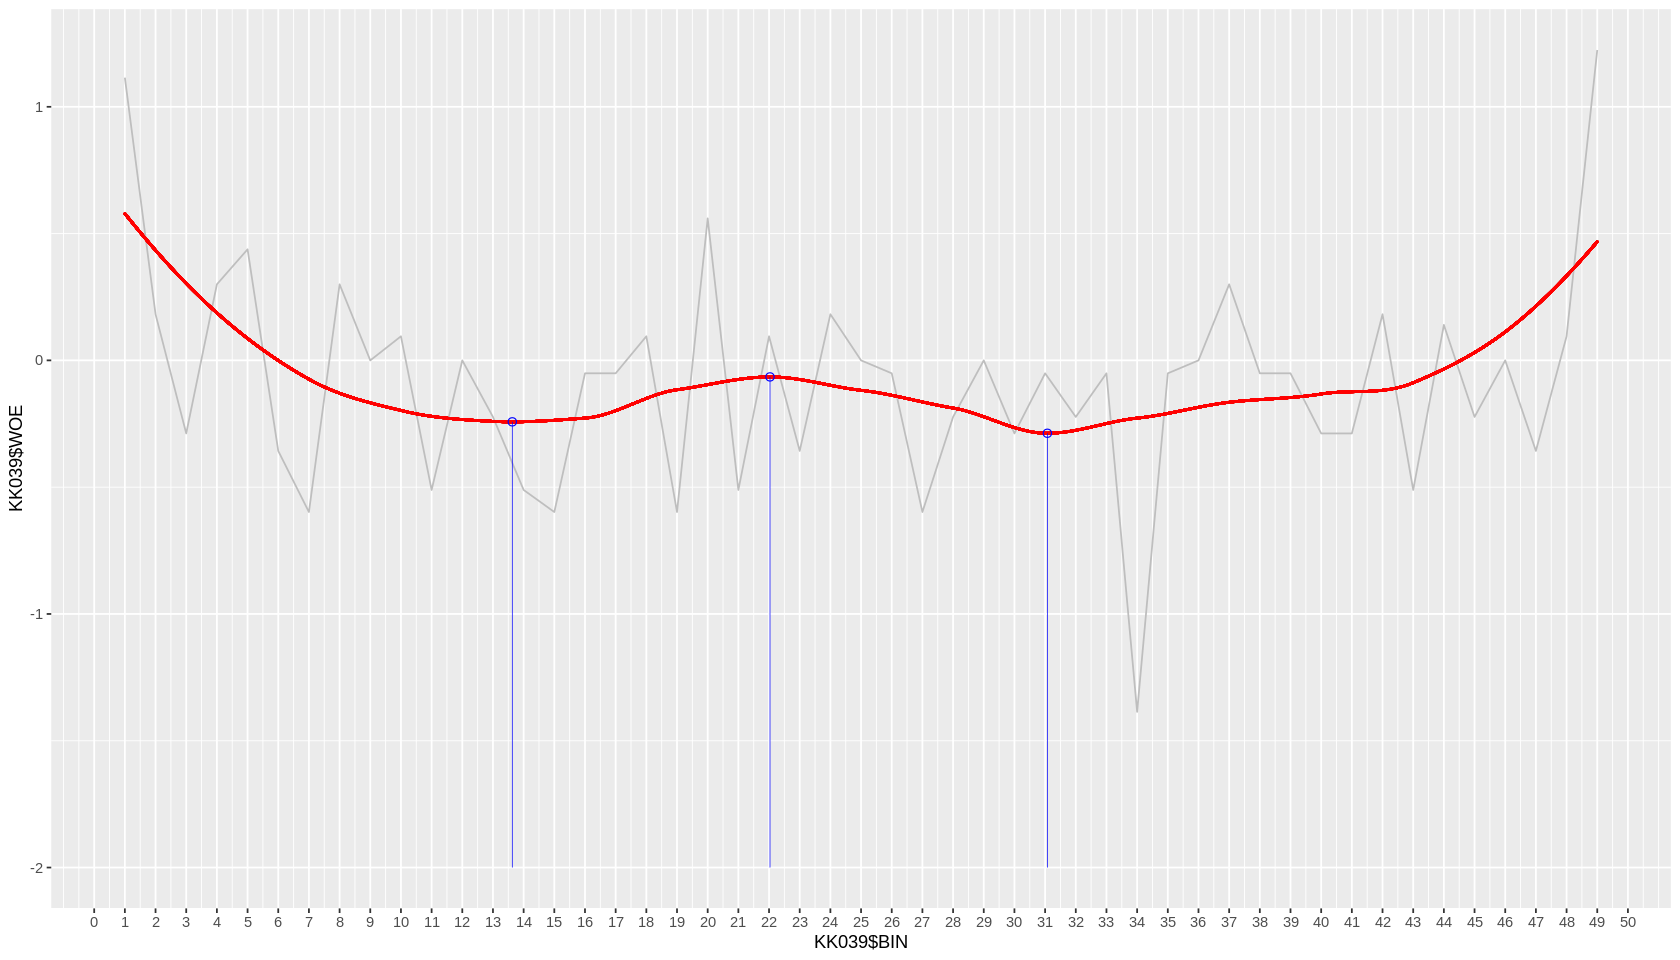

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_KK039<- loess(KK039$WOE~KK039$BIN, span=0.45)
xl_KK039  <- seq(min(KK039$BIN),max(KK039$BIN), (max(KK039$BIN)-min(KK039$BIN))/200000)
out_KK039 <- predict(smoothing_KK039, xl_KK039)
infl_KK039<- c(diff(diff(out_KK039)>0)!=0,F,F)

### LINE ----
sdata_KK039 <- data.table(xl_KK039,out_KK039, infl_KK039)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_KK039, aes(KK039$BIN,KK039$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_KK039, aes(xl_KK039, out_KK039), size=.1, color="red") +
  geom_point(data=sdata_KK039[infl_KK039], aes(xl_KK039, out_KK039), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_KK039[infl_KK039], aes(x=xl_KK039, y=-2, xend=xl_KK039, yend=out_KK039),color='blue', size=0.2) +
   scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl_KK039]

xl,out,infl
<dbl>,<dbl>,<lgl>
13.63024,-0.07934722,FALSE
22.03144,-0.20181954,FALSE
31.07392,-0.24457739,FALSE


- BINNING 결과 테이블

In [ ]:
a <- subset(KK039, BIN <= 13 )
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(KK039, BIN > 13 & BIN <=22)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])

c <- subset(KK039, BIN  > 22 & BIN <=31)
c$cum_bad <- cumsum(c$BAD)
c$cum_good <- cumsum(c$GOOD)
c$cum_total <- cumsum(c$TOTAL)
c1 <- rbind(head(c,1), tail(c, 1))
c2 <- data.table(c1[1,c(2)], c1[2,c(3,14,15,16)])

d <- subset(KK039, BIN >31 )
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])

total <- rbind(a2,b2,c2,d2)
BIN <- c(1,2,3,4)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,-3601310.0,15.8,34657,222,34879
2,15.8,28.7,24027,120,24147
3,28.7,48.4,24030,117,24147
4,48.4,8309323.0,48003,276,48279


- KK097 ( OCF대매출액비율 ) : 현금흐름

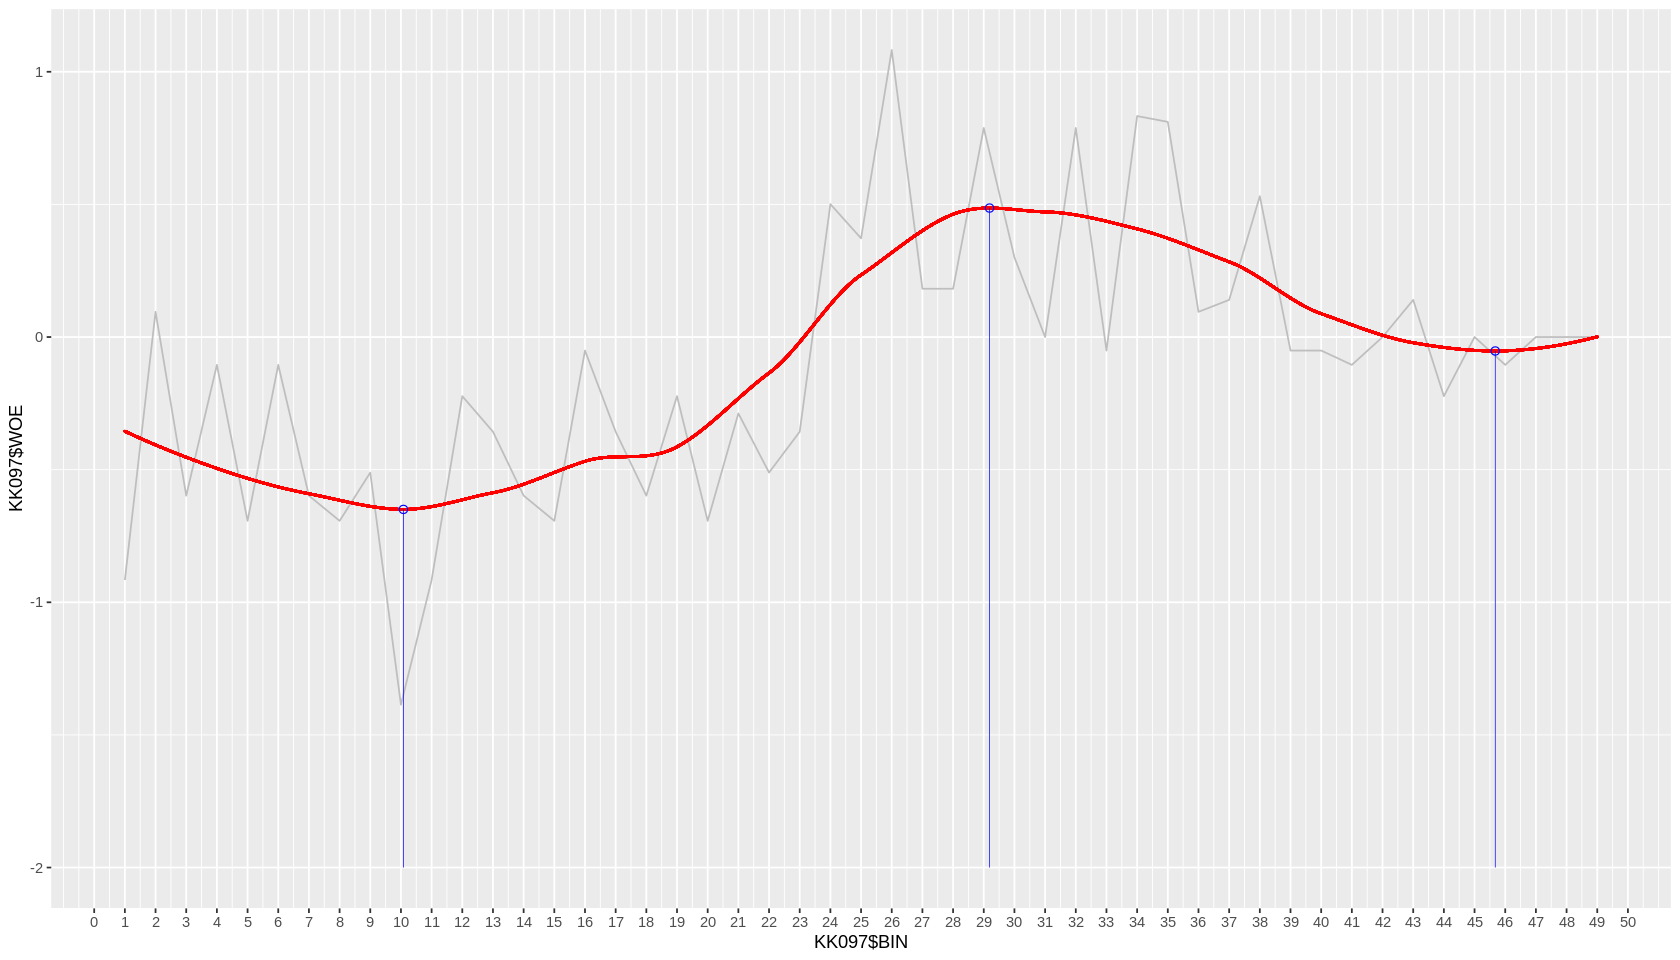

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_KK097<- loess(KK097$WOE~KK097$BIN, span=0.45)
xl_KK097  <- seq(min(KK097$BIN),max(KK097$BIN), (max(KK097$BIN)-min(KK097$BIN))/200000)
out_KK097 <- predict(smoothing_KK097, xl_KK097)
infl_KK097<- c(diff(diff(out_KK097)>0)!=0,F,F)

### LINE ----
sdata_KK097 <- data.table(xl_KK097,out_KK097, infl_KK097)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_KK097, aes(KK097$BIN,KK097$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_KK097, aes(xl_KK097, out_KK097), size=.1, color="red") +
  geom_point(data=sdata_KK097[infl_KK097], aes(xl_KK097, out_KK097), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_KK097[infl_KK097], aes(x=xl_KK097, y=-2, xend=xl_KK097, yend=out_KK097),color='blue', size=0.2) +
   scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl_KK097]

xl,out,infl
<dbl>,<dbl>,<lgl>
10.08136,0.06526742,FALSE
29.18896,-0.26333353,FALSE
45.67504,-0.24043243,FALSE


- BINNING 결과 테이블

In [ ]:
a <- subset(KK097, BIN <= 10 )
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(KK097, BIN > 10 & BIN <=45)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])


d <- subset(KK097, BIN > 45 )
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])

total <- rbind(a2,b2,d2)
BIN <- c(1,2,3)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,-153,0,26739,91,26830
2,0,0,93319,586,93905
3,0,183,10659,58,10717


- KK018(순차입금/EBITDA ) : 현금흐름

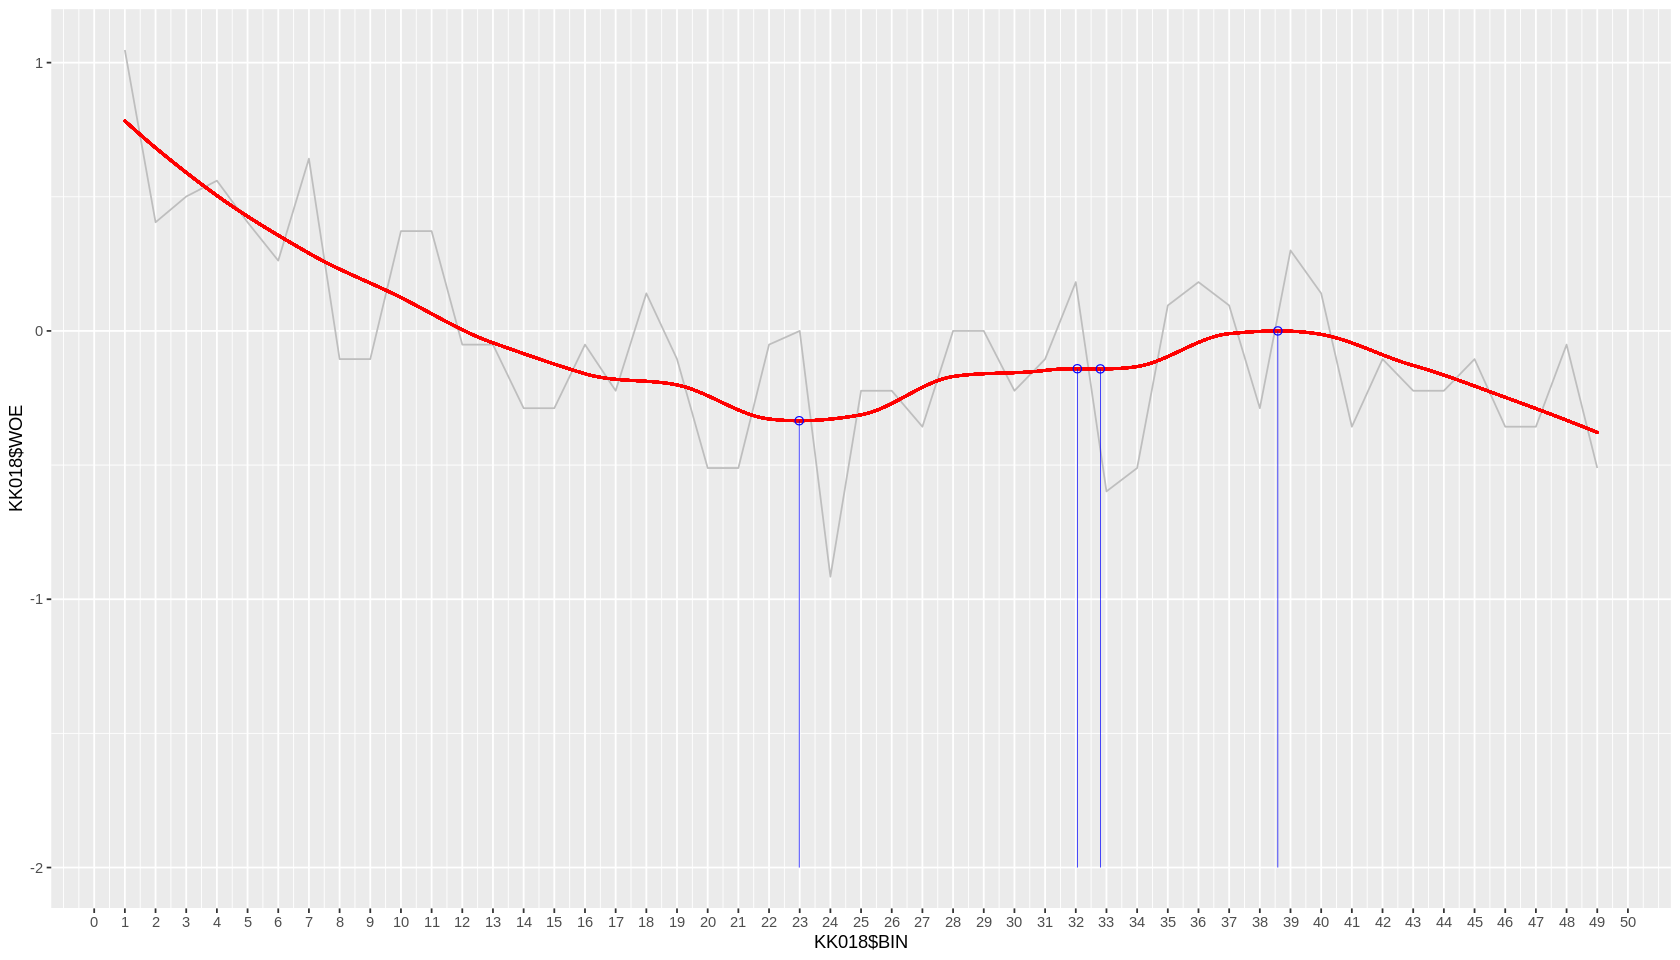

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_KK018<- loess(KK018$WOE~KK018$BIN, span=0.4)
xl_KK018  <- seq(min(KK018$BIN),max(KK018$BIN), (max(KK018$BIN)-min(KK018$BIN))/200000)
out_KK018 <- predict(smoothing_KK018, xl_KK018)
infl_KK018<- c(diff(diff(out_KK018)>0)!=0,F,F)

### LINE ----
sdata_KK018 <- data.table(xl_KK018,out_KK018, infl_KK018)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_KK018, aes(KK018$BIN,KK018$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_KK018, aes(xl_KK018, out_KK018), size=.1, color="red") +
  geom_point(data=sdata_KK018[infl_KK018], aes(xl_KK018, out_KK018), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_KK018[infl_KK018], aes(x=xl_KK018, y=-2, xend=xl_KK018, yend=out_KK018),color='blue', size=0.2) +
  scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl_KK018]

xl,out,infl
<dbl>,<dbl>,<lgl>
22.98376,-0.2041395535,FALSE
32.05072,-0.2394095879,FALSE
32.80120,-0.2360329306,FALSE
38.58736,0.0006673535,FALSE


- BINNING 결과 테이블

In [ ]:
a <- subset(KK018, BIN <= 23 )
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(KK018, BIN > 23 & BIN <=32)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])

c <- subset(KK018, BIN  > 32 & BIN <=38)
c$cum_bad <- cumsum(c$BAD)
c$cum_good <- cumsum(c$GOOD)
c$cum_total <- cumsum(c$TOTAL)
c1 <- rbind(head(c,1), tail(c, 1))
c2 <- data.table(c1[1,c(2)], c1[2,c(3,14,15,16)])

d <- subset(KK018, BIN >38 )
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])

total <- rbind(a2,b2,c2,d2)
BIN <- c(1,2,3,4)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,-3749.0,11.1,61305,404,61709
2,11.1,15.4,24034,113,24147
3,15.4,19.9,16020,78,16098
4,19.9,108.0,29358,140,29498


- KK015(EBIT/총금융비용) : 현금흐름 

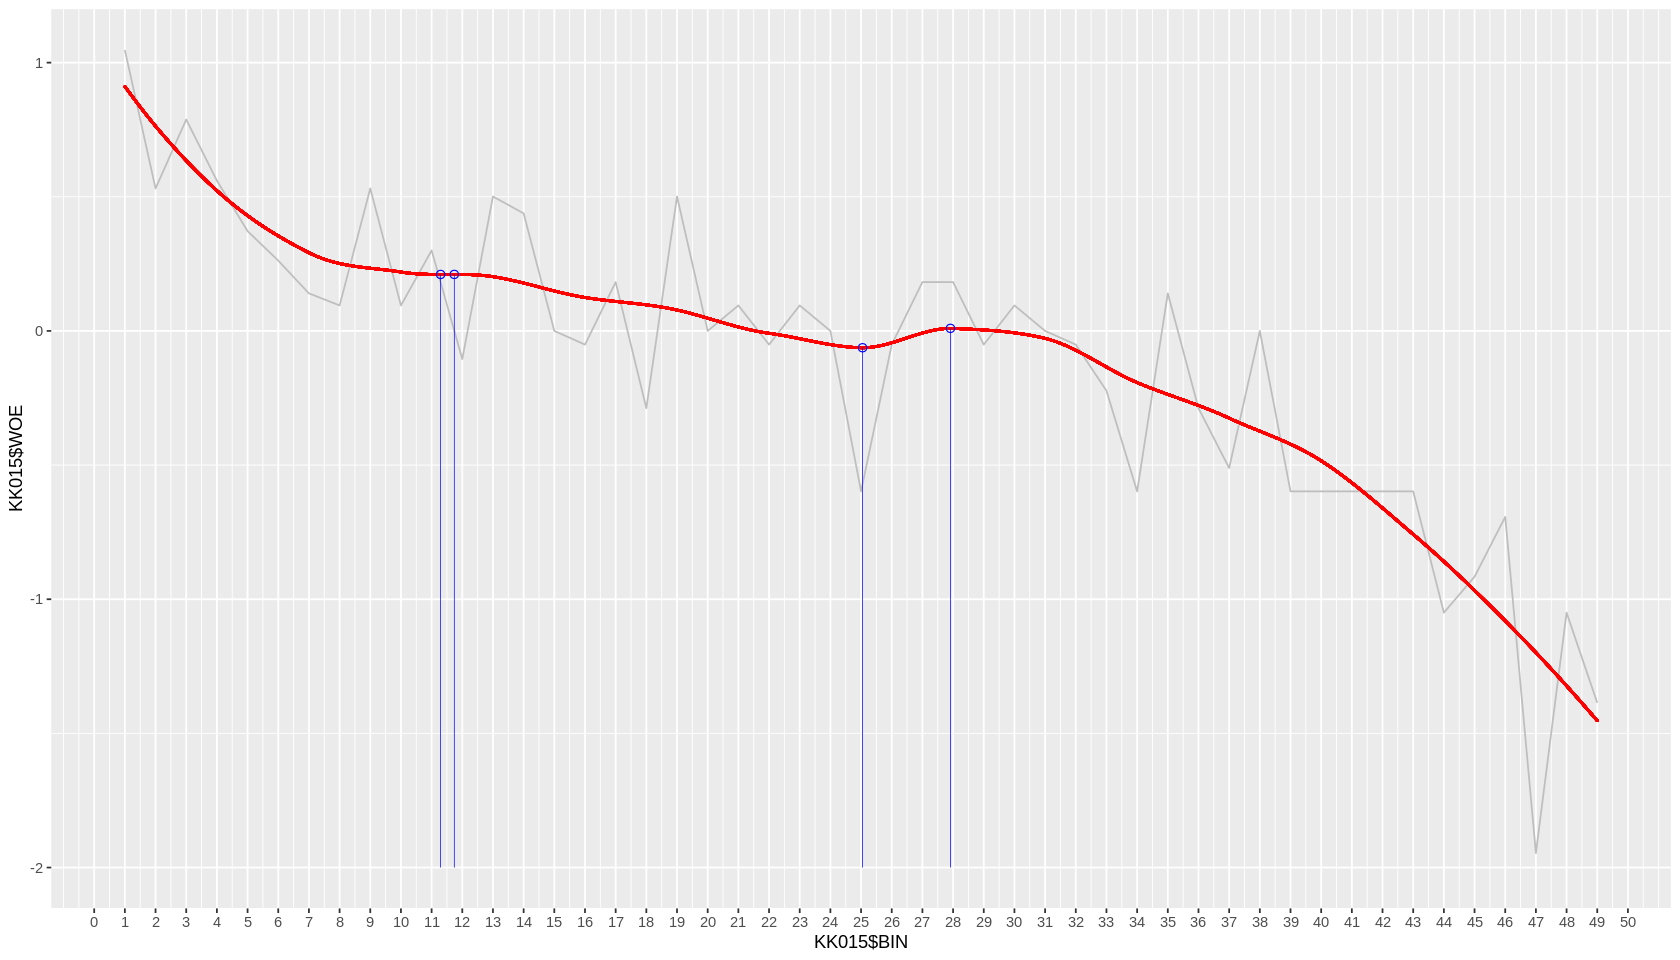

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_KK015<- loess(KK015$WOE~KK015$BIN, span=0.4)
xl_KK015  <- seq(min(KK015$BIN),max(KK015$BIN), (max(KK015$BIN)-min(KK015$BIN))/200000)
out_KK015 <- predict(smoothing_KK015, xl_KK015)
infl_KK015<- c(diff(diff(out_KK015)>0)!=0,F,F)

### LINE ----
sdata_KK015 <- data.table(xl_KK015,out_KK015, infl_KK015)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_KK015, aes(KK015$BIN,KK015$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_KK015, aes(xl_KK015, out_KK015), size=.1, color="red") +
  geom_point(data=sdata_KK015[infl_KK015], aes(xl_KK015, out_KK015), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_KK015[infl_KK015], aes(x=xl_KK015, y=-2, xend=xl_KK015, yend=out_KK015),color='blue', size=0.2) +
  scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl_KK015]

xl,out,infl
<dbl>,<dbl>,<lgl>
11.29288,0.010123195,FALSE
11.73904,-0.008142839,FALSE
25.04848,-0.213269324,FALSE
27.91432,-0.268161228,FALSE


- BINNING 결과 테이블

In [ ]:
a <- subset(KK015, BIN <= 11 )
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(KK015, BIN > 11 & BIN <=25)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])

c <- subset(KK015, BIN  > 25 & BIN <=28)
c$cum_bad <- cumsum(c$BAD)
c$cum_good <- cumsum(c$GOOD)
c$cum_total <- cumsum(c$TOTAL)
c1 <- rbind(head(c,1), tail(c, 1))
c2 <- data.table(c1[1,c(2)], c1[2,c(3,14,15,16)])

d <- subset(KK015, BIN  > 28 )
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])



total <- rbind(a2,b2,c2,d2)
BIN <- c(1,2,3,4)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,-7321850,348,29254,259,29513
2,348,771,37336,226,37562
3,771,921,7999,50,8049
4,921,38578000,56128,200,56328


- KK057(EBITDA/총금융비용 ) : 현금흐름 or 안정성

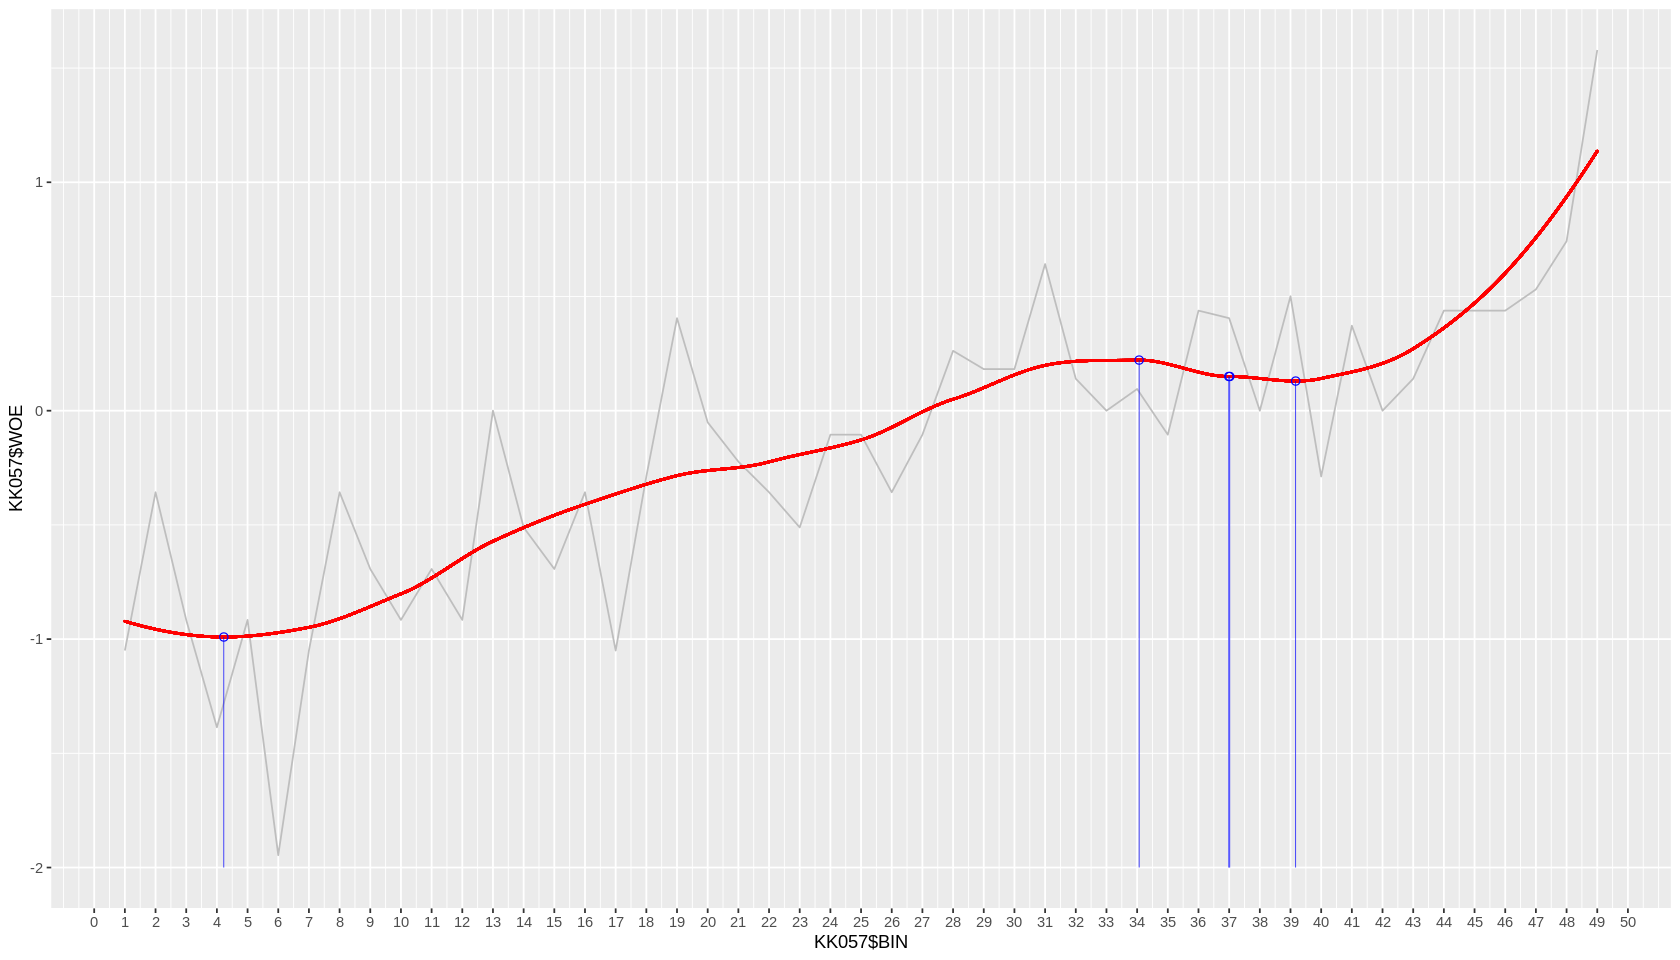

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_KK057<- loess(KK057$WOE~KK057$BIN, span=0.45)
xl_KK057  <- seq(min(KK057$BIN),max(KK057$BIN), (max(KK057$BIN)-min(KK057$BIN))/200000)
out_KK057 <- predict(smoothing_KK057, xl_KK057)
infl_KK057<- c(diff(diff(out_KK057)>0)!=0,F,F)

### LINE ----
sdata_KK057 <- data.table(xl_KK057,out_KK057, infl_KK057)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_KK057, aes(KK057$BIN,KK057$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_KK057, aes(xl_KK057, out_KK057), size=.1, color="red") +
  geom_point(data=sdata_KK057[infl_KK057], aes(xl_KK057, out_KK057), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_KK057[infl_KK057], aes(x=xl_KK057, y=-2, xend=xl_KK057, yend=out_KK057),color='blue', size=0.2) +
  scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl_KK057]

xl,out,infl
<dbl>,<dbl>,<lgl>
4.22560,0.45425086,FALSE
34.06528,-0.21880604,FALSE
36.98920,-0.07646327,FALSE
37.02016,-0.07551912,FALSE
39.16912,0.02718342,FALSE


- BINNING 결과 테이블

In [ ]:
options(digits = 3)
options(scipen=999)

a <- subset(KK057, BIN <= 4 )
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(KK057, BIN > 4 & BIN <=34)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])

c <- subset(KK057, BIN  > 34 & BIN <=37)
c$cum_bad <- cumsum(c$BAD)
c$cum_good <- cumsum(c$GOOD)
c$cum_total <- cumsum(c$TOTAL)
c1 <- rbind(head(c,1), tail(c, 1))
c2 <- data.table(c1[1,c(2)], c1[2,c(3,14,15,16)])

d <- subset(KK057, BIN  > 37 & BIN <=39)
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])

e <- subset(KK057, BIN  > 39)
e$cum_bad <- cumsum(e$BAD)
e$cum_good <- cumsum(e$GOOD)
e$cum_total <- cumsum(e$TOTAL)
e1 <- rbind(head(e,1), tail(e, 1))
e2 <- data.table(e1[1,c(2)], e1[2,c(3,14,15,16)])


total <- rbind(a2,b2,c2,d2, e2)
BIN <- c(1,2,3,4,5)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,0.0,35.3,10707,25,10732
2,35.3,358.0,80137,353,80490
3,358.0,442.0,7991,58,8049
4,442.0,522.0,5327,39,5366
5,522.0,34629990.0,26555,260,26815


- KK112(부채비율) : 안정성

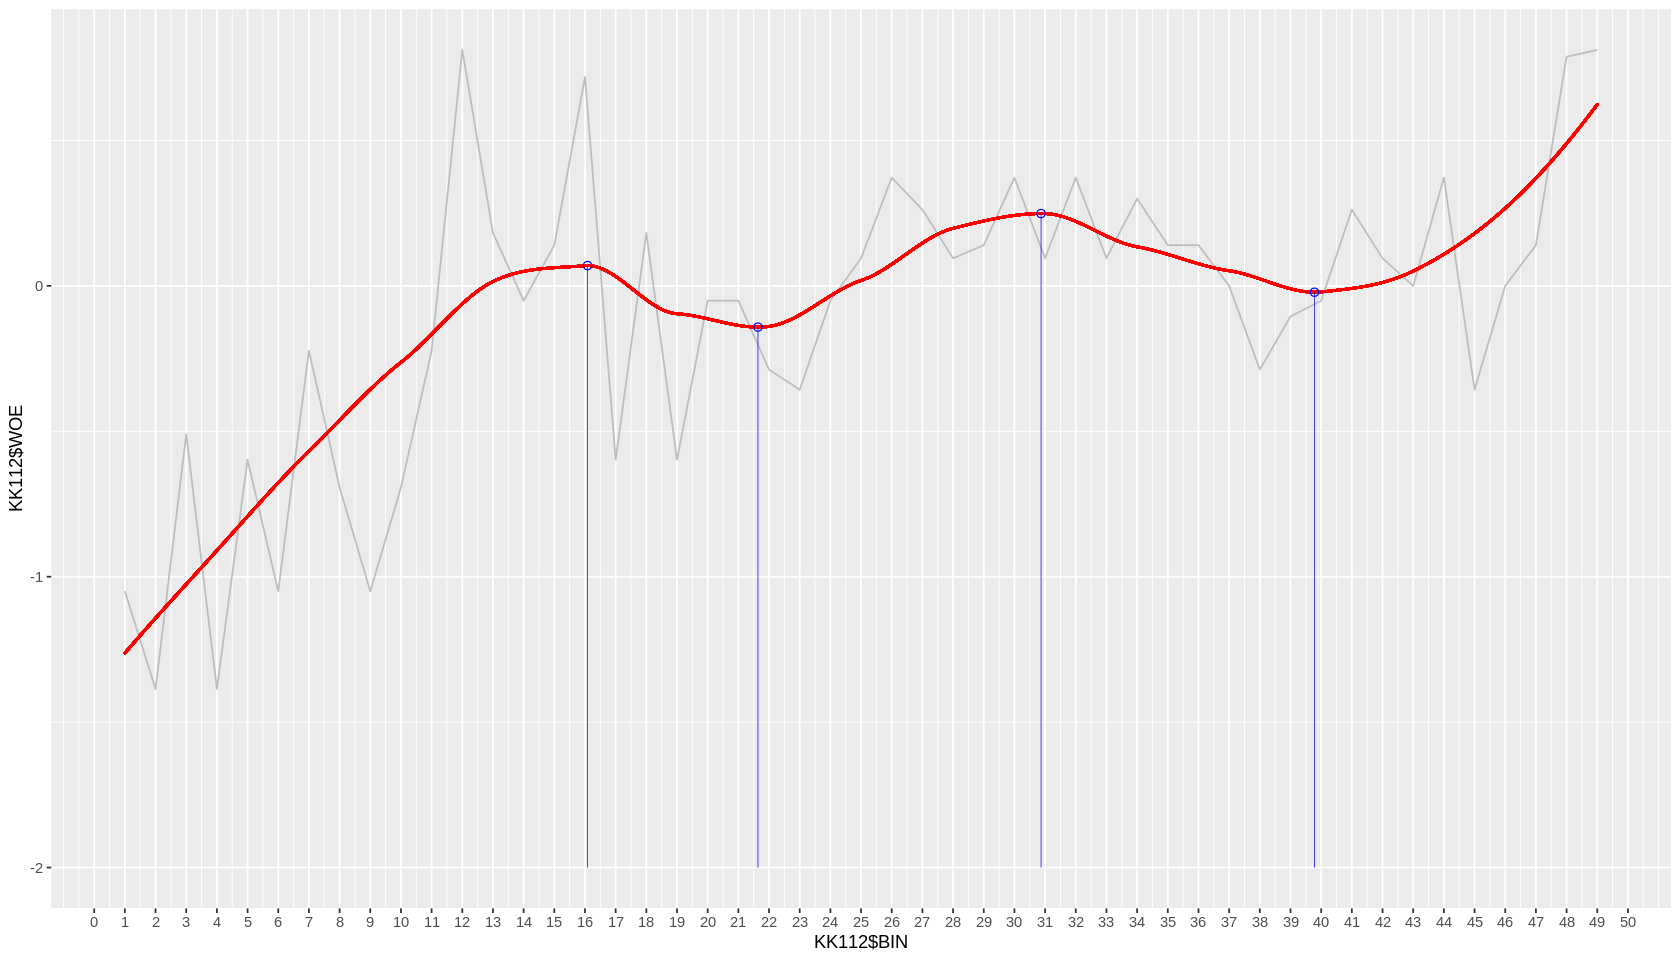

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_KK112<- loess(KK112$WOE~KK112$BIN, span=0.5)
xl_KK112  <- seq(min(KK112$BIN),max(KK112$BIN), (max(KK112$BIN)-min(KK112$BIN))/200000)
out_KK112 <- predict(smoothing_KK112, xl_KK112)
infl_KK112<- c(diff(diff(out_KK112)>0)!=0,F,F)

### LINE ----
sdata_KK112 <- data.table(xl_KK112,out_KK112, infl_KK112)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_KK112, aes(KK112$BIN,KK112$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_KK112, aes(xl_KK112, out_KK112), size=.1, color="red") +
  geom_point(data=sdata_KK112[infl_KK112], aes(xl_KK112, out_KK112), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_KK112[infl_KK112], aes(x=xl_KK112, y=-2, xend=xl_KK112, yend=out_KK112),color='blue', size=0.2) +
  scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl_KK112]

xl,out,infl
<dbl>,<dbl>,<lgl>
16.08256,-0.16102554,FALSE
21.63904,-0.20252977,FALSE
30.86800,-0.24649296,FALSE
39.78088,0.04215765,FALSE


- BINNING 결과 테이블

In [ ]:
a <- subset(KK112, BIN <= 30 )
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])


d <- subset(KK112, BIN  > 30 & BIN <=39 )
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])

e <- subset(KK112, BIN >39 )
e$cum_bad <- cumsum(e$BAD)
e$cum_good <- cumsum(e$GOOD)
e$cum_total <- cumsum(e$TOTAL)
e1 <- rbind(head(e,1), tail(e, 1))
e2 <- data.table(e1[1,c(2)], e1[2,c(3,14,15,16)])

total <- rbind(a2,d2,e2)
BIN <- c(1,2,3)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,0.00,9.58,80093,397,80490
2,9.58,32.60,24001,146,24147
3,32.60,488.00,26623,192,26815


- KK060(단기차입금의존도) : 안정성 지표


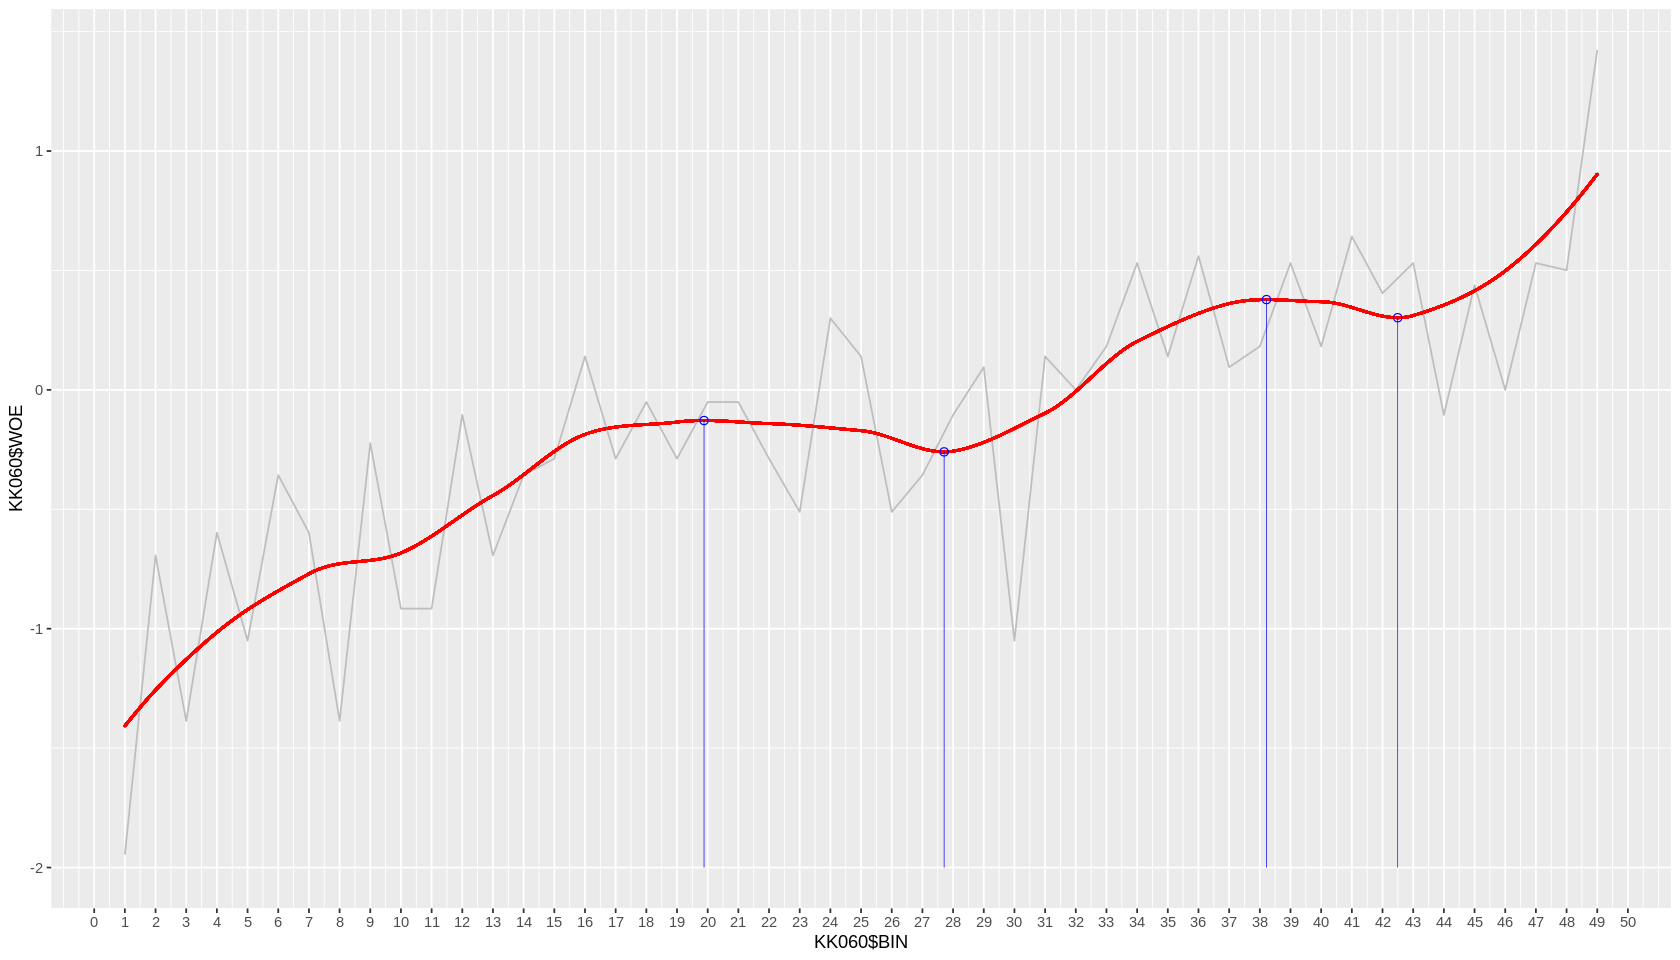

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_KK060<- loess(KK060$WOE~KK060$BIN, span=0.4)
xl_KK060  <- seq(min(KK060$BIN),max(KK060$BIN), (max(KK060$BIN)-min(KK060$BIN))/200000)
out_KK060 <- predict(smoothing_KK060, xl_KK060)
infl_KK060<- c(diff(diff(out_KK060)>0)!=0,F,F)

### LINE ----
sdata_KK060 <- data.table(xl_KK060,out_KK060, infl_KK060)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_KK060, aes(KK060$BIN,KK060$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_KK060, aes(xl_KK060, out_KK060), size=.1, color="red") +
  geom_point(data=sdata_KK060[infl_KK060], aes(xl_KK060, out_KK060), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_KK060[infl_KK060], aes(x=xl_KK060, y=-2, xend=xl_KK060, yend=out_KK060),color='blue', size=0.2) +
  scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))
  

In [ ]:
sdata[infl_KK060]

xl,out,infl
<dbl>,<dbl>,<lgl>
19.88128,-0.22705356,FALSE
27.70816,-0.26686174,FALSE
38.21752,-0.01916972,FALSE
42.49504,0.00525388,FALSE


- BINNING 결과 테이블

In [ ]:
a <- subset(KK060, BIN <= 20 )
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(KK060, BIN > 20 & BIN <=27)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])

c <- subset(KK060, BIN  > 27 & BIN <=38)
c$cum_bad <- cumsum(c$BAD)
c$cum_good <- cumsum(c$GOOD)
c$cum_total <- cumsum(c$TOTAL)
c1 <- rbind(head(c,1), tail(c, 1))
c2 <- data.table(c1[1,c(2)], c1[2,c(3,14,15,16)])

d <- subset(KK060, BIN  > 38 & BIN <=42 )
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])

e <- subset(KK060, BIN >39 )
e$cum_bad <- cumsum(e$BAD)
e$cum_good <- cumsum(e$GOOD)
e$cum_total <- cumsum(e$TOTAL)
e1 <- rbind(head(e,1), tail(e, 1))
e2 <- data.table(e1[1,c(2)], e1[2,c(3,14,15,16)])

total <- rbind(a2,b2,c2,d2,e2)
BIN <- c(1,2,3,4,5)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,0.0,44.5,53480,180,53660
2,44.5,55.5,18691,90,18781
3,55.5,70.9,29327,186,29513
4,70.9,77.3,10639,93,10732
5,72.4,1489.0,26561,254,26815


- KK022(부채상환계수) : 안정성 지표

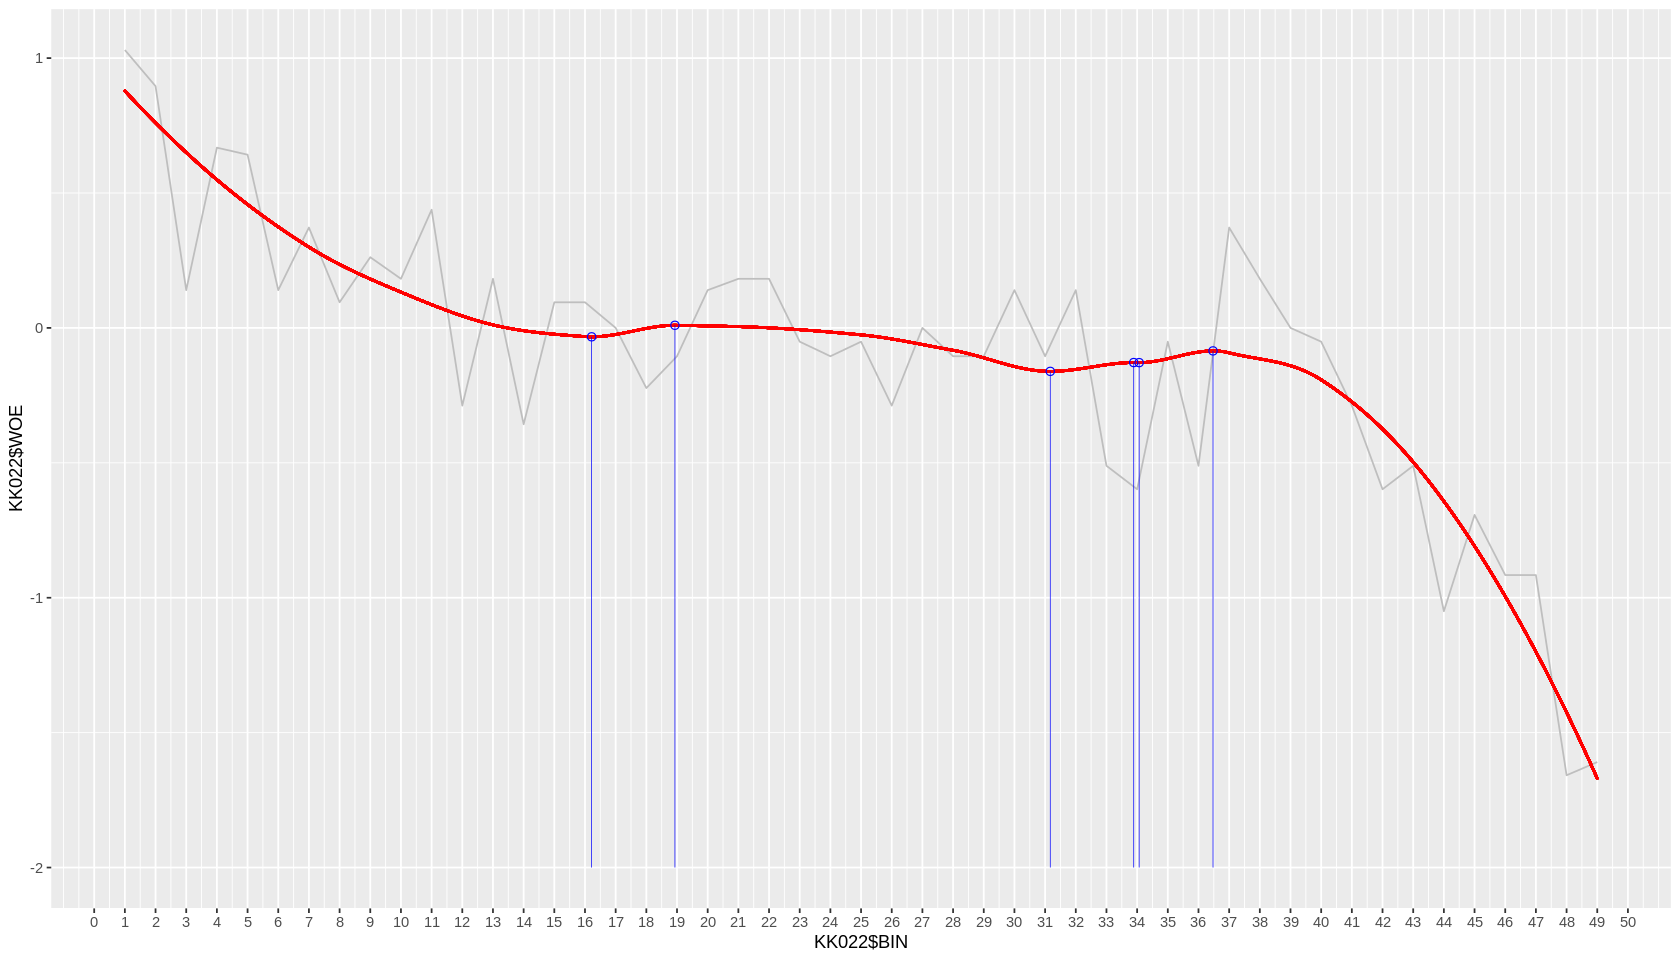

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_KK022<- loess(KK022$WOE~KK022$BIN, span=0.45)
xl_KK022  <- seq(min(KK022$BIN),max(KK022$BIN), (max(KK022$BIN)-min(KK022$BIN))/200000)
out_KK022 <- predict(smoothing_KK022, xl_KK022)
infl_KK022<- c(diff(diff(out_KK022)>0)!=0,F,F)

### LINE ----
sdata_KK022 <- data.table(xl_KK022,out_KK022, infl_KK022)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_KK022, aes(KK022$BIN,KK022$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_KK022, aes(xl_KK022, out_KK022), size=.1, color="red") +
  geom_point(data=sdata_KK022[infl_KK022], aes(xl_KK022, out_KK022), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_KK022[infl_KK022], aes(x=xl_KK022, y=-2, xend=xl_KK022, yend=out_KK022),color='blue', size=0.2) +
  scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl_KK022]

xl,out,infl
<dbl>,<dbl>,<lgl>
16.21624,-0.16438490,FALSE
18.93208,-0.22559044,FALSE
31.16824,-0.24381455,FALSE
33.88888,-0.22270908,FALSE
34.06600,-0.21878789,FALSE
36.47392,-0.09697808,FALSE


- BINNING 결과 테이블

In [ ]:
a <- subset(KK022, BIN <= 16)
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(KK022, BIN > 16 & BIN <=19)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])

c <- subset(KK022, BIN  > 19 & BIN <=31)
c$cum_bad <- cumsum(c$BAD)
c$cum_good <- cumsum(c$GOOD)
c$cum_total <- cumsum(c$TOTAL)
c1 <- rbind(head(c,1), tail(c, 1))
c2 <- data.table(c1[1,c(2)], c1[2,c(3,14,15,16)])

d <- subset(KK022, BIN  > 31 & BIN <=34 )
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])

e <- subset(KK022, BIN  > 34 & BIN <=36 )
e$cum_bad <- cumsum(e$BAD)
e$cum_good <- cumsum(e$GOOD)
e$cum_total <- cumsum(e$TOTAL)
e1 <- rbind(head(e,1), tail(e, 1))
e2 <- data.table(e1[1,c(2)], e1[2,c(3,14,15,16)])

f <- subset(KK022, BIN >36)
f$cum_bad <- cumsum(f$BAD)
f$cum_good <- cumsum(f$GOOD)
f$cum_total <- cumsum(f$TOTAL)
f1 <- rbind(head(f,1), tail(f, 1))
f2 <- data.table(f1[1,c(2)], f1[2,c(3,14,15,16)])

total <- rbind(a2,b2,c2,d2,e2,f2)
BIN <- c(1,2,3,4,5,6)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,-962395.0,90.8,42592,336,42928
2,90.8,128.0,8009,40,8049
3,128.0,467.0,32020,176,32196
4,467.0,639.0,8015,34,8049
5,639.0,798.0,5343,23,5366
6,798.0,25721050.0,34738,126,34864


- KK030(매출액증가율) : 성장성 지표

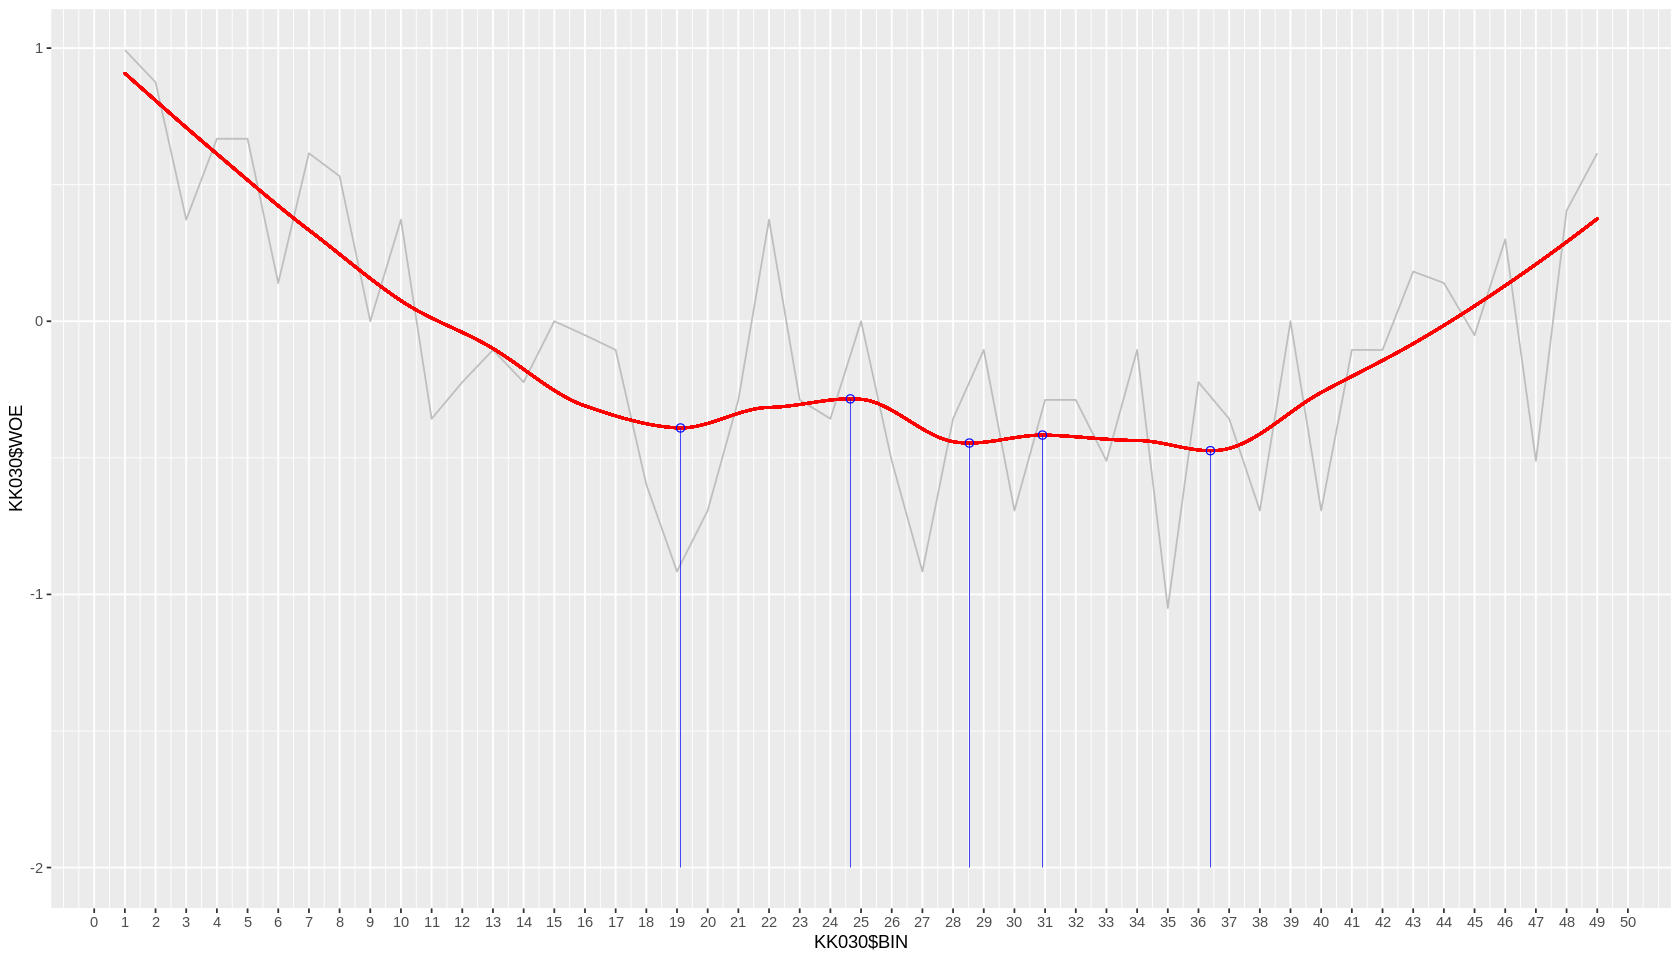

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_KK030<- loess(KK030$WOE~KK030$BIN, span=0.4)
xl_KK030  <- seq(min(KK030$BIN),max(KK030$BIN), (max(KK030$BIN)-min(KK030$BIN))/200000)
out_KK030 <- predict(smoothing_KK030, xl_KK030)
infl_KK030<- c(diff(diff(out_KK030)>0)!=0,F,F)

### LINE ----
sdata_KK030 <- data.table(xl_KK030,out_KK030, infl_KK030)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_KK030, aes(KK030$BIN,KK030$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_KK030, aes(xl_KK030, out_KK030), size=.1, color="red") +
  geom_point(data=sdata_KK030[infl_KK030], aes(xl_KK030, out_KK030), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_KK030[infl_KK030], aes(x=xl_KK030, y=-2, xend=xl_KK030, yend=out_KK030),color='blue', size=0.2) +
  scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl_KK030]

xl,out,infl
<dbl>,<dbl>,<lgl>
19.11448,-0.2279244,FALSE
24.65056,-0.2105814,FALSE
28.53088,-0.2674436,FALSE
30.91456,-0.2460433,FALSE
36.38968,-0.1010887,FALSE


- BINNING 결과 테이블

In [ ]:
a <- subset(KK030, BIN <= 19)
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(KK030, BIN > 19 & BIN <=24)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])

c <- subset(KK030, BIN  > 24 & BIN <=28)
c$cum_bad <- cumsum(c$BAD)
c$cum_good <- cumsum(c$GOOD)
c$cum_total <- cumsum(c$TOTAL)
c1 <- rbind(head(c,1), tail(c, 1))
c2 <- data.table(c1[1,c(2)], c1[2,c(3,14,15,16)])

d <- subset(KK030, BIN  > 28 & BIN <=31 )
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])

e <- subset(KK030, BIN  > 31 & BIN <=36 )
e$cum_bad <- cumsum(e$BAD)
e$cum_good <- cumsum(e$GOOD)
e$cum_total <- cumsum(e$TOTAL)
e1 <- rbind(head(e,1), tail(e, 1))
e2 <- data.table(e1[1,c(2)], e1[2,c(3,14,15,16)])

f <- subset(KK030, BIN >36)
f$cum_bad <- cumsum(f$BAD)
f$cum_good <- cumsum(f$GOOD)
f$cum_total <- cumsum(f$TOTAL)
f1 <- rbind(head(f,1), tail(f, 1))
f2 <- data.table(f1[1,c(2)], f1[2,c(3,14,15,16)])

total <- rbind(a2,b2,c2,d2,e2,f2)
BIN <- c(1,2,3,4,5,6)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,-100.000,-0.631,50615,362,50977
2,-0.631,4.800,13355,60,13415
3,4.800,9.950,10692,40,10732
4,9.950,14.600,8018,31,8049
5,14.600,25.100,13365,50,13415
6,25.100,5799210.000,34672,192,34864


- KK025(총자산증가율) : 성장성 지표

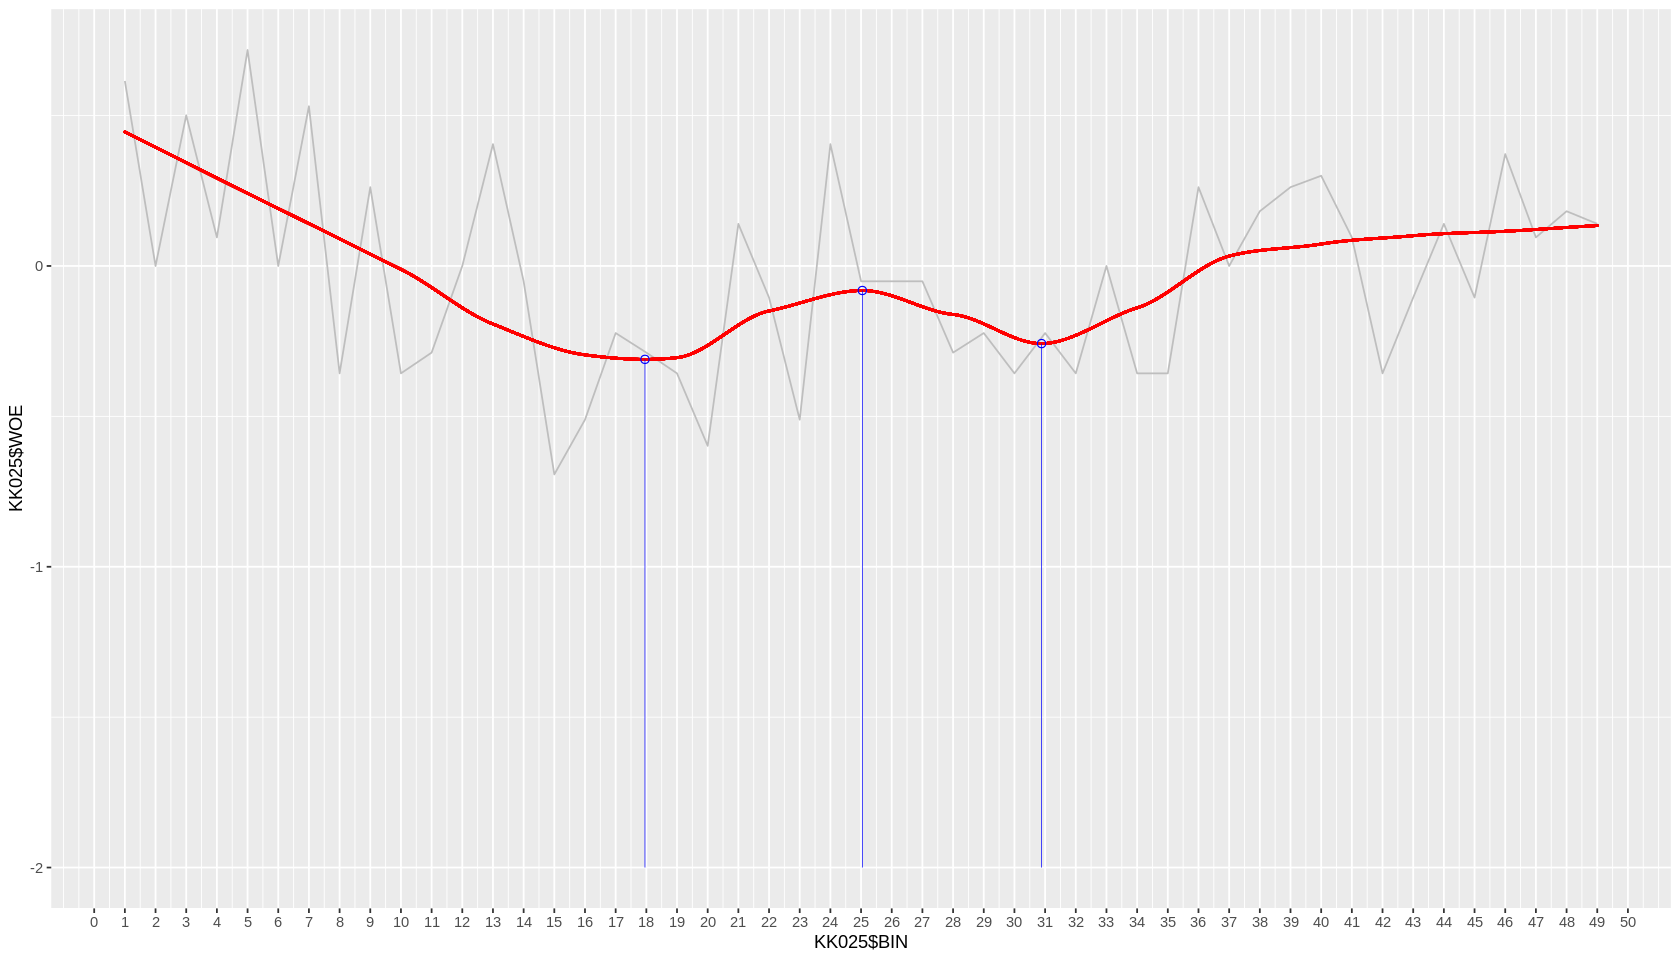

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_KK025 <- loess(KK025$WOE~KK025$BIN, span=0.45)
xl_KK025  <- seq(min(KK025$BIN),max(KK025$BIN), (max(KK025$BIN)-min(KK025$BIN))/200000)
out_KK025 <- predict(smoothing_KK025, xl_KK025)
infl_KK025<- c(diff(diff(out_KK025)>0)!=0,F,F)

### LINE ----
sdata_KK025 <- data.table(xl_KK025,out_KK025, infl_KK025)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_KK025, aes(KK025$BIN,KK025$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_KK025, aes(xl_KK025, out_KK025), size=.1, color="red") +
  geom_point(data=sdata_KK025[infl_KK025], aes(xl_KK025, out_KK025), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_KK025[infl_KK025], aes(x=xl_KK025, y=-2, xend=xl_KK025, yend=out_KK025),color='blue', size=0.2) +
  scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl_KK025]

xl,out,infl
<dbl>,<dbl>,<lgl>
17.95504,-0.2073509,FALSE
25.04152,-0.2132105,FALSE
30.88432,-0.2463346,FALSE


- BINNING 결과 테이블

In [ ]:
a <- subset(KK025, BIN <= 18)
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(KK025, BIN > 18 & BIN <=25)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])

c <- subset(KK025, BIN  > 25 & BIN <=31)
c$cum_bad <- cumsum(c$BAD)
c$cum_good <- cumsum(c$GOOD)
c$cum_total <- cumsum(c$TOTAL)
c1 <- rbind(head(c,1), tail(c, 1))
c2 <- data.table(c1[1,c(2)], c1[2,c(3,14,15,16)])

d <- subset(KK025, BIN  > 31 )
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])

total <- rbind(a2,b2,c2,d2)
BIN <- c(1,2,3,4)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,-99.8000,-0.0859,48002,292,48294
2,-0.0858,5.5800,18688,93,18781
3,5.5800,14.0000,16025,73,16098
4,14.0000,432823.0000,48002,277,48279


- KK137(총자산회전율) : 성장성 지표

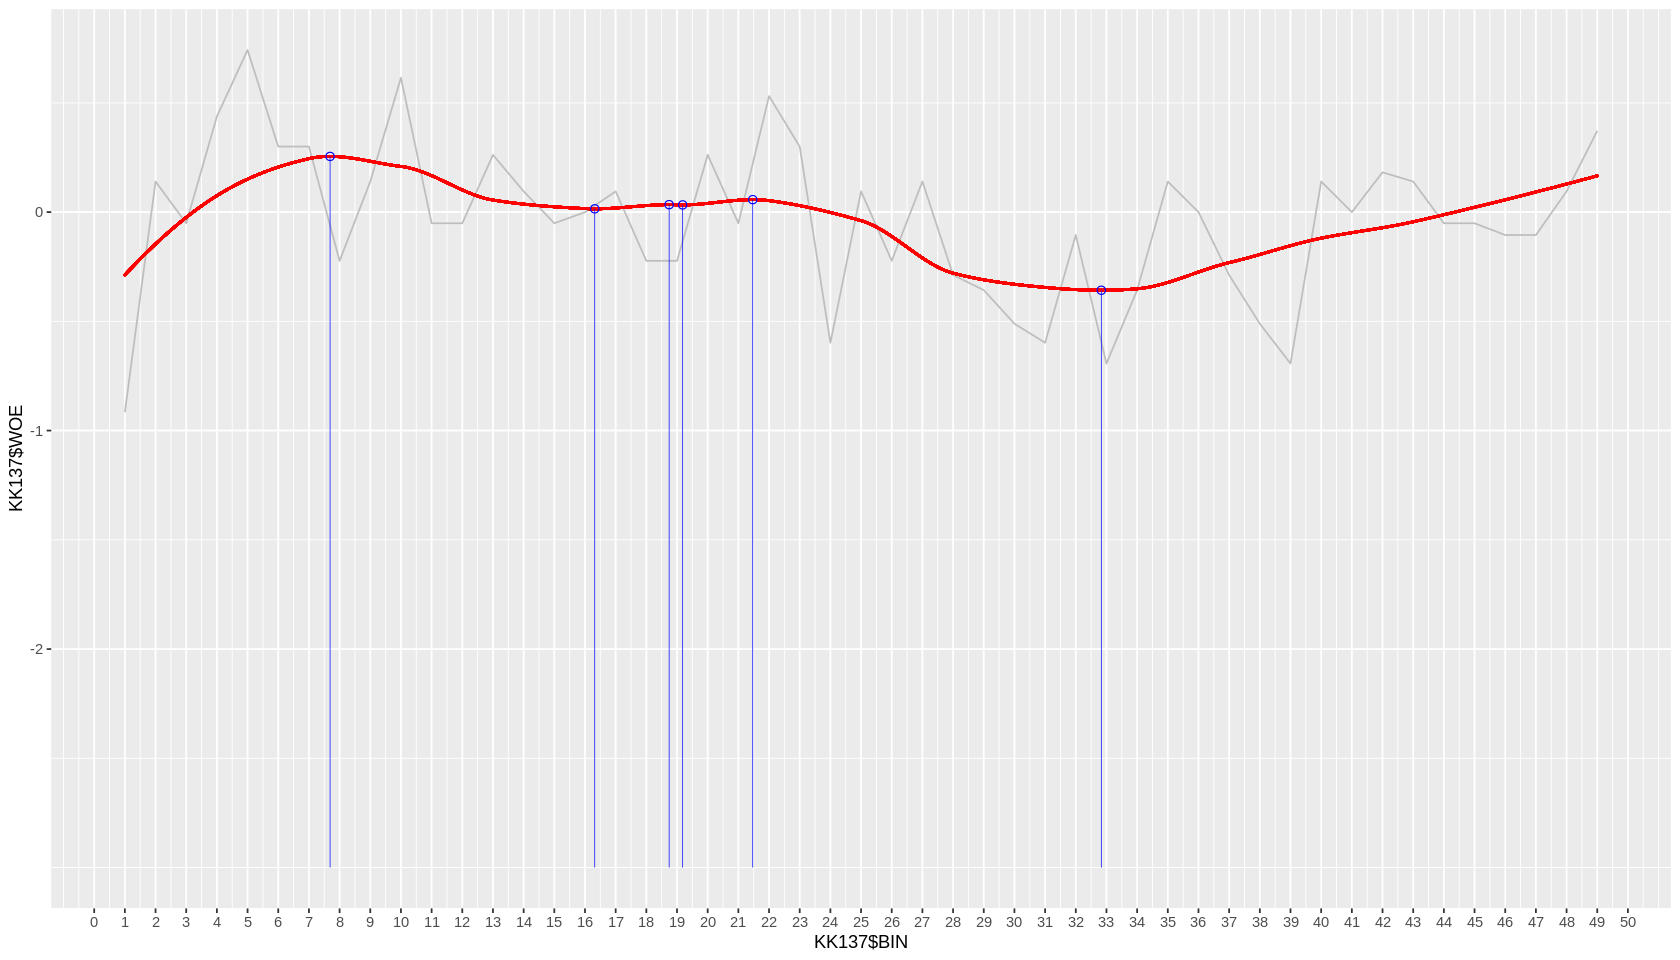

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_KK137 <- loess(KK137$WOE~KK137$BIN, span=0.45)
xl_KK137  <- seq(min(KK137$BIN),max(KK137$BIN), (max(KK137$BIN)-min(KK137$BIN))/200000)
out_KK137 <- predict(smoothing_KK137, xl_KK137)
infl_KK137<- c(diff(diff(out_KK137)>0)!=0,F,F)

### LINE ----
sdata_KK137 <- data.table(xl_KK137,out_KK137, infl_KK137)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_KK137, aes(KK137$BIN,KK137$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_KK137, aes(xl_KK137, out_KK137), size=.1, color="red") +
  geom_point(data=sdata_KK137[infl_KK137], aes(xl_KK137, out_KK137), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_KK137[infl_KK137], aes(x=xl_KK137, y=-3, xend=xl_KK137, yend=out_KK137),color='blue', size=0.2) +
  scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl_KK137]

xl,out,infl
<dbl>,<dbl>,<lgl>
7.68976,0.1819922,FALSE
16.31800,-0.1669643,FALSE
18.74344,-0.2226636,FALSE
19.18432,-0.2285322,FALSE
21.46864,-0.2039355,FALSE
32.83192,-0.2358356,FALSE


- BINNING 결과 테이블

In [ ]:
a <- subset(KK137, BIN <= 7)
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(KK137, BIN > 7 & BIN <=16)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])

c <- subset(KK137, BIN  > 16 & BIN <=18)
c$cum_bad <- cumsum(c$BAD)
c$cum_good <- cumsum(c$GOOD)
c$cum_total <- cumsum(c$TOTAL)
c1 <- rbind(head(c,1), tail(c, 1))
c2 <- data.table(c1[1,c(2)], c1[2,c(3,14,15,16)])

d <- subset(KK137, BIN  > 18 & BIN <=21 )
d$cum_bad <- cumsum(d$BAD)
d$cum_good <- cumsum(d$GOOD)
d$cum_total <- cumsum(d$TOTAL)
d1 <- rbind(head(d,1), tail(d, 1))
d2 <- data.table(d1[1,c(2)], d1[2,c(3,14,15,16)])

e <- subset(KK137, BIN  > 21 & BIN <=32 )
e$cum_bad <- cumsum(e$BAD)
e$cum_good <- cumsum(e$GOOD)
e$cum_total <- cumsum(e$TOTAL)
e1 <- rbind(head(e,1), tail(e, 1))
e2 <- data.table(e1[1,c(2)], e1[2,c(3,14,15,16)])

f <- subset(KK137, BIN >32)
f$cum_bad <- cumsum(f$BAD)
f$cum_good <- cumsum(f$GOOD)
f$cum_total <- cumsum(f$TOTAL)
f1 <- rbind(head(f,1), tail(f, 1))
f2 <- data.table(f1[1,c(2)], f1[2,c(3,14,15,16)])

total <- rbind(a2,b2,c2,d2,e2,f2)
BIN <- c(1,2,3,4,5,6)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total

BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,0.000,0.556,18650,131,18781
2,0.556,1.018,23999,148,24147
3,1.018,1.120,5338,28,5366
4,1.120,1.300,8004,45,8049
5,1.300,2.180,29364,149,29513
6,2.180,195.000,45362,234,45596


- KK081(재고자산회전율) : 성장성 지표

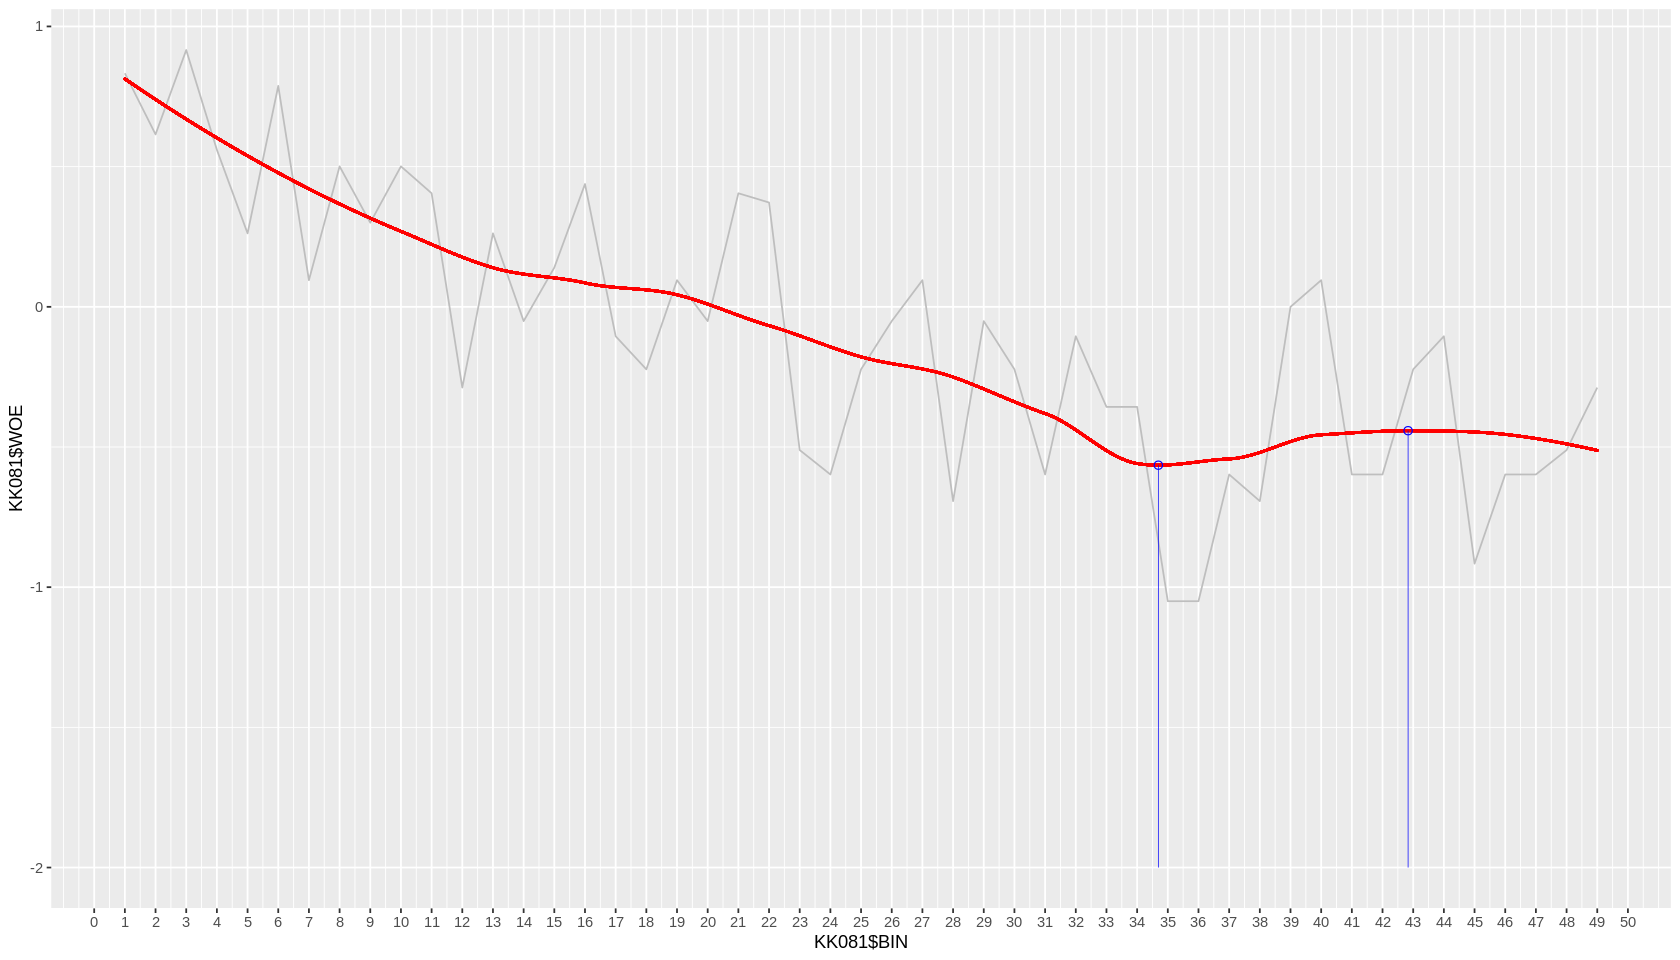

In [ ]:
## Smoothing -------------------------------------------------------------------
smoothing_KK081 <- loess(KK081$WOE~KK081$BIN, span=0.45)
xl_KK081 <- seq(min(KK081$BIN),max(KK081$BIN), (max(KK081$BIN)-min(KK081$BIN))/200000)
out_KK081 <- predict(smoothing_KK081, xl_KK081)
infl_KK081<- c(diff(diff(out_KK081)>0)!=0,F,F)

### LINE ----
sdata_KK081 <- data.table(xl_KK081,out_KK081, infl_KK081)
options(repr.plot.width = 14, repr.plot.height = 8)
ggplot(data_KK081, aes(KK081$BIN,KK081$WOE)) + geom_path(color="gray") +
  geom_point(data=sdata_KK081, aes(xl_KK081, out_KK081), size=.1, color="red") +
  geom_point(data=sdata_KK081[infl_KK081], aes(xl_KK081, out_KK081), size=2, color="blue", shape=1) +
  geom_segment(data=sdata_KK081[infl_KK081], aes(x=xl_KK081, y=-2, xend=xl_KK081, yend=out_KK081),color='blue', size=0.2) +
  scale_x_continuous(breaks=seq(0, 50, 1))+
  scale_y_continuous(breaks=c(-2, -1, 0 ,1))

In [ ]:
sdata[infl_KK081]

xl,out,infl
<dbl>,<dbl>,<lgl>
34.69144,-0.19549643,FALSE
42.83344,-0.01055977,FALSE


- BINNING 결과 테이블

In [ ]:
a <- subset(KK081, BIN <= 34)
a$cum_bad <- cumsum(a$BAD)
a$cum_good <- cumsum(a$GOOD)
a$cum_total <- cumsum(a$TOTAL)
a1 <- rbind(head(a,1), tail(a, 1))
a2 <- data.table(a1[1,c(2)], a1[2,c(3,14,15,16)])

b <- subset(KK081, BIN > 34 & BIN <=42)
b$cum_bad <- cumsum(b$BAD)
b$cum_good <- cumsum(b$GOOD)
b$cum_total <- cumsum(b$TOTAL)
b1 <- rbind(head(b,1), tail(b, 1))
b2 <- data.table(b1[1,c(2)], b1[2,c(3,14,15,16)])

c <- subset(KK081, BIN  > 42)
c$cum_bad <- cumsum(c$BAD)
c$cum_good <- cumsum(c$GOOD)
c$cum_total <- cumsum(c$TOTAL)
c1 <- rbind(head(c,1), tail(c, 1))
c2 <- data.table(c1[1,c(2)], c1[2,c(3,14,15,16)])


total <- rbind(a2,b2,c2)
BIN <- c(1,2,3)
total <- rename(total, c("MIN"="V1", "GOOD"="cum_bad", "BAD"="cum_good", "TOTAL"="cum_total"))
total <- data.frame(BIN, total)
total



BIN,MIN,MAX,GOOD,BAD,TOTAL
<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,0,360,90626,596,91222
2,360,471266,21392,72,21464
3,471307,43592140,18699,67,18766
